<p style="text-align: center;">
<big><big><big><b>Practical 7: Neural Networks</b></big></big></big>
</p>

### The task

This practical we will consider predicting monthly (4 week) per household spend (low/med/high) using neural networks.

### Data
We will use data in the table:
`transaction_data_small`


### Data documentation
The full documentation can be found [here](https://drive.google.com/file/d/1Ioozg-V5NJB5wDwoPXDhdZEbClABRZqd/view). Note the full data source [is avaliable onine](https://www.dunnhumby.com/careers/engineering/sourcefiles). However, please use the copy already loaded into your database.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [2]:
###############################################################################
#####                     REQUIRED PACKAGES                              ######
###############################################################################
# TensorFlow and Keras setup

#!pip install tensorflow-hub 
#!pip install tensorflow
#!pip install keras
#!pip install category_encoders 
!pip install tb-nightly


In [1]:
import pandas as pd
import numpy as np

In [2]:
#Import data as pandas dataframe
data = pd.read_csv('transaction_data_small.csv', header = 0,index_col=0)

In [3]:
data.shape

(497807, 12)

In [4]:
data.head(5)

household_key    BASKET_ID  DAY  PRODUCT_ID  QUANTITY  SALES_VALUE  \
24             98  26984951769    1      878302         3         0.90   
25             98  26984951769    1      965138         2         3.00   
26             98  26984951769    1      985911         1         1.25   
27             98  26984951769    1     1082185         1         0.39   
28             98  26984951769    1     1087347         1         0.25   

    STORE_ID  RETAIL_DISC  TRANS_TIME  WEEK_NO  COUPON_DISC  COUPON_MATCH_DISC  
24       337         0.00        1937        1          0.0                0.0  
25       337        -0.08        1937        1          0.0                0.0  
26       337        -0.34        1937        1          0.0                0.0  
27       337         0.00        1937        1          0.0                0.0  
28       337         0.00        1937        1          0.0                0.0

In [5]:
def get_dataset(rd, tws = 28, ows =28):
    #Select rows with DAY smaller than 700 and group the data by 'household_key'
    data2 = data[data['DAY'] <= 700].groupby('household_key')
    df = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd][x['DAY'] <= rd+ows]['SALES_VALUE'].sum()).reset_index(name ='output_feature'))
    df1 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws][x['DAY'] <= rd]['SALES_VALUE'].sum()).reset_index(name ='f1'))
    df2 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*2][x['DAY'] <= rd-tws]['SALES_VALUE'].sum()).reset_index(name ='f2'))
    df3 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*3][x['DAY'] <= rd-tws*2]['SALES_VALUE'].sum()).reset_index(name ='f3'))
    df4 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*4][x['DAY'] <= rd-tws*3]['SALES_VALUE'].sum()).reset_index(name ='f4'))
    df5 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*5][x['DAY'] <= rd-tws*4]['SALES_VALUE'].sum()).reset_index(name ='f5'))
    df6 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*6][x['DAY'] <= rd-tws*5]['SALES_VALUE'].sum()).reset_index(name ='f6'))
    df7 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*7][x['DAY'] <= rd-tws*6]['SALES_VALUE'].sum()).reset_index(name ='f7'))
    df8 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*8][x['DAY'] <= rd-tws*7]['SALES_VALUE'].sum()).reset_index(name ='f8'))
    df9 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*9][x['DAY'] <= rd-tws*8]['SALES_VALUE'].sum()).reset_index(name ='f9'))
    df10 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*10][x['DAY'] <= rd-tws*9]['SALES_VALUE'].sum()).reset_index(name ='f10'))
    dfs = [df, df1, df2, df3, df4, df5, df6, df7, df8, df9, df10]
    dfs = [df.set_index('household_key') for df in dfs]
    df_join = dfs[0].join(dfs[1:])
    return df_join.drop(columns = ['output_feature'], inplace = False), df_join.output_feature

## 1. Load a single hold-out test set, including a validation set.

Recall there are 711 days in the data. However, we need all periods to be fully covered (there is very little data in the last 28 day period since only 11 days are within the data range). Therefore our effective data size is 700 days.

The function, given a reference date in days, returns 10 tumbling window features, where each feature is an aggregate (SUM) over 28 days.
The output feature is the aggregate over the 28 days immediatly proceeding the reference date. It only uses the first 700 days. 

If you still unsure how to do this ask and/or read this [story about Bob and Jane](https://docs.google.com/document/d/1wIZARovA8NXOJ2OBjAW7Lw5QjtovDHlLbdxl6VAMW0M/edit?usp=sharing).

### Step 1: Given the above information, select the reference date for the test set and create the variables X_test y_test

### Step 2: Given the above information, select the reference date for the validation set and create the variables X_valid y_valid

### Step 3: Select the the reference date for the training set and create the variables X_train, y_train


In [6]:
# Step 1
#Tumbling windows are a series of fixed-sized, non-overlapping and contiguous time intervals. 
# Test reference date should be 28 days (length output feature is aggregated over)
# from the end date (700), therefore: 700-28 = 672
# Note: we should also quickly check if we have enough data for the function to return
#       10 historic months, i.e. 28*10 < 672 (which it is)
X_test, y_test  = get_dataset(672)

# Step 2
# Validation reference date should be 28 days (length output feature is aggregated over)
# from the test reference date (672), therefore: 672-28 = 644
# Note: we should also quickly check if we have enough data for the function to return
#       10 historic months, i.e. 28*10 < 644 (which it is)
X_valid, y_valid  = get_dataset(644)

# Step 3
# Train reference date should be 28 days (length output feature is aggregated over)
# from the test reference date (672), therefore: 644-28 = 616
# Note: we should also quickly check if we have enough data for the function to return
#       10 historic months, i.e. 28*10 < 616 (which it is)
X_train, y_train  = get_dataset(616)

<ipython-input-5-e3fde143e9d7>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd][x['DAY'] <= rd+ows]['SALES_VALUE'].sum()).reset_index(name ='output_feature'))
<ipython-input-5-e3fde143e9d7>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd][x['DAY'] <= rd+ows]['SALES_VALUE'].sum()).reset_index(name ='output_feature'))
<ipython-input-5-e3fde143e9d7>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd][x['DAY'] <= rd+ows]['SALES_VALUE'].sum()).reset_index(name ='output_feature'))
<ipython-input-5-e3fde143e9d7>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd][x['DAY'] <= rd+ows]['SALES_VALUE'].sum()).reset_index(name ='output_feature'))
<ipython

<ipython-input-5-e3fde143e9d7>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd][x['DAY'] <= rd+ows]['SALES_VALUE'].sum()).reset_index(name ='output_feature'))
<ipython-input-5-e3fde143e9d7>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd][x['DAY'] <= rd+ows]['SALES_VALUE'].sum()).reset_index(name ='output_feature'))
<ipython-input-5-e3fde143e9d7>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd][x['DAY'] <= rd+ows]['SALES_VALUE'].sum()).reset_index(name ='output_feature'))
<ipython-input-5-e3fde143e9d7>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd][x['DAY'] <= rd+ows]['SALES_VALUE'].sum()).reset_index(name ='output_feature'))
<ipython

<ipython-input-5-e3fde143e9d7>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd][x['DAY'] <= rd+ows]['SALES_VALUE'].sum()).reset_index(name ='output_feature'))
<ipython-input-5-e3fde143e9d7>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd][x['DAY'] <= rd+ows]['SALES_VALUE'].sum()).reset_index(name ='output_feature'))
<ipython-input-5-e3fde143e9d7>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd][x['DAY'] <= rd+ows]['SALES_VALUE'].sum()).reset_index(name ='output_feature'))
<ipython-input-5-e3fde143e9d7>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd][x['DAY'] <= rd+ows]['SALES_VALUE'].sum()).reset_index(name ='output_feature'))
<ipython

<ipython-input-5-e3fde143e9d7>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd][x['DAY'] <= rd+ows]['SALES_VALUE'].sum()).reset_index(name ='output_feature'))
<ipython-input-5-e3fde143e9d7>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd][x['DAY'] <= rd+ows]['SALES_VALUE'].sum()).reset_index(name ='output_feature'))
<ipython-input-5-e3fde143e9d7>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd][x['DAY'] <= rd+ows]['SALES_VALUE'].sum()).reset_index(name ='output_feature'))
<ipython-input-5-e3fde143e9d7>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd][x['DAY'] <= rd+ows]['SALES_VALUE'].sum()).reset_index(name ='output_feature'))
<ipython

<ipython-input-5-e3fde143e9d7>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd][x['DAY'] <= rd+ows]['SALES_VALUE'].sum()).reset_index(name ='output_feature'))
<ipython-input-5-e3fde143e9d7>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd][x['DAY'] <= rd+ows]['SALES_VALUE'].sum()).reset_index(name ='output_feature'))
<ipython-input-5-e3fde143e9d7>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd][x['DAY'] <= rd+ows]['SALES_VALUE'].sum()).reset_index(name ='output_feature'))
<ipython-input-5-e3fde143e9d7>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd][x['DAY'] <= rd+ows]['SALES_VALUE'].sum()).reset_index(name ='output_feature'))
<ipython

<ipython-input-5-e3fde143e9d7>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd][x['DAY'] <= rd+ows]['SALES_VALUE'].sum()).reset_index(name ='output_feature'))
<ipython-input-5-e3fde143e9d7>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd][x['DAY'] <= rd+ows]['SALES_VALUE'].sum()).reset_index(name ='output_feature'))
<ipython-input-5-e3fde143e9d7>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd][x['DAY'] <= rd+ows]['SALES_VALUE'].sum()).reset_index(name ='output_feature'))
<ipython-input-5-e3fde143e9d7>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd][x['DAY'] <= rd+ows]['SALES_VALUE'].sum()).reset_index(name ='output_feature'))
<ipython

<ipython-input-5-e3fde143e9d7>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd][x['DAY'] <= rd+ows]['SALES_VALUE'].sum()).reset_index(name ='output_feature'))
<ipython-input-5-e3fde143e9d7>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd][x['DAY'] <= rd+ows]['SALES_VALUE'].sum()).reset_index(name ='output_feature'))
<ipython-input-5-e3fde143e9d7>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd][x['DAY'] <= rd+ows]['SALES_VALUE'].sum()).reset_index(name ='output_feature'))
<ipython-input-5-e3fde143e9d7>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd][x['DAY'] <= rd+ows]['SALES_VALUE'].sum()).reset_index(name ='output_feature'))
<ipython

<ipython-input-5-e3fde143e9d7>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws][x['DAY'] <= rd]['SALES_VALUE'].sum()).reset_index(name ='f1'))
<ipython-input-5-e3fde143e9d7>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws][x['DAY'] <= rd]['SALES_VALUE'].sum()).reset_index(name ='f1'))
<ipython-input-5-e3fde143e9d7>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws][x['DAY'] <= rd]['SALES_VALUE'].sum()).reset_index(name ='f1'))
<ipython-input-5-e3fde143e9d7>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws][x['DAY'] <= rd]['SALES_VALUE'].sum()).reset_index(name ='f1'))
<ipython-input-5-e3fde143e9d7>:5: UserWarning: Boole

<ipython-input-5-e3fde143e9d7>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws][x['DAY'] <= rd]['SALES_VALUE'].sum()).reset_index(name ='f1'))
<ipython-input-5-e3fde143e9d7>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws][x['DAY'] <= rd]['SALES_VALUE'].sum()).reset_index(name ='f1'))
<ipython-input-5-e3fde143e9d7>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws][x['DAY'] <= rd]['SALES_VALUE'].sum()).reset_index(name ='f1'))
<ipython-input-5-e3fde143e9d7>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws][x['DAY'] <= rd]['SALES_VALUE'].sum()).reset_index(name ='f1'))
<ipython-input-5-e3fde143e9d7>:5: UserWarning: Boole

<ipython-input-5-e3fde143e9d7>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws][x['DAY'] <= rd]['SALES_VALUE'].sum()).reset_index(name ='f1'))
<ipython-input-5-e3fde143e9d7>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws][x['DAY'] <= rd]['SALES_VALUE'].sum()).reset_index(name ='f1'))
<ipython-input-5-e3fde143e9d7>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws][x['DAY'] <= rd]['SALES_VALUE'].sum()).reset_index(name ='f1'))
<ipython-input-5-e3fde143e9d7>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws][x['DAY'] <= rd]['SALES_VALUE'].sum()).reset_index(name ='f1'))
<ipython-input-5-e3fde143e9d7>:5: UserWarning: Boole

<ipython-input-5-e3fde143e9d7>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws][x['DAY'] <= rd]['SALES_VALUE'].sum()).reset_index(name ='f1'))
<ipython-input-5-e3fde143e9d7>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws][x['DAY'] <= rd]['SALES_VALUE'].sum()).reset_index(name ='f1'))
<ipython-input-5-e3fde143e9d7>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws][x['DAY'] <= rd]['SALES_VALUE'].sum()).reset_index(name ='f1'))
<ipython-input-5-e3fde143e9d7>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws][x['DAY'] <= rd]['SALES_VALUE'].sum()).reset_index(name ='f1'))
<ipython-input-5-e3fde143e9d7>:5: UserWarning: Boole

<ipython-input-5-e3fde143e9d7>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*2][x['DAY'] <= rd-tws]['SALES_VALUE'].sum()).reset_index(name ='f2'))
<ipython-input-5-e3fde143e9d7>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*2][x['DAY'] <= rd-tws]['SALES_VALUE'].sum()).reset_index(name ='f2'))
<ipython-input-5-e3fde143e9d7>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*2][x['DAY'] <= rd-tws]['SALES_VALUE'].sum()).reset_index(name ='f2'))
<ipython-input-5-e3fde143e9d7>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*2][x['DAY'] <= rd-tws]['SALES_VALUE'].sum()).reset_index(name ='f2'))
<ipython-input-5-e3fde143e9d

<ipython-input-5-e3fde143e9d7>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*2][x['DAY'] <= rd-tws]['SALES_VALUE'].sum()).reset_index(name ='f2'))
<ipython-input-5-e3fde143e9d7>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*2][x['DAY'] <= rd-tws]['SALES_VALUE'].sum()).reset_index(name ='f2'))
<ipython-input-5-e3fde143e9d7>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*2][x['DAY'] <= rd-tws]['SALES_VALUE'].sum()).reset_index(name ='f2'))
<ipython-input-5-e3fde143e9d7>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*2][x['DAY'] <= rd-tws]['SALES_VALUE'].sum()).reset_index(name ='f2'))
<ipython-input-5-e3fde143e9d

<ipython-input-5-e3fde143e9d7>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*2][x['DAY'] <= rd-tws]['SALES_VALUE'].sum()).reset_index(name ='f2'))
<ipython-input-5-e3fde143e9d7>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*2][x['DAY'] <= rd-tws]['SALES_VALUE'].sum()).reset_index(name ='f2'))
<ipython-input-5-e3fde143e9d7>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*2][x['DAY'] <= rd-tws]['SALES_VALUE'].sum()).reset_index(name ='f2'))
<ipython-input-5-e3fde143e9d7>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*2][x['DAY'] <= rd-tws]['SALES_VALUE'].sum()).reset_index(name ='f2'))
<ipython-input-5-e3fde143e9d

<ipython-input-5-e3fde143e9d7>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*2][x['DAY'] <= rd-tws]['SALES_VALUE'].sum()).reset_index(name ='f2'))
<ipython-input-5-e3fde143e9d7>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*2][x['DAY'] <= rd-tws]['SALES_VALUE'].sum()).reset_index(name ='f2'))
<ipython-input-5-e3fde143e9d7>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*2][x['DAY'] <= rd-tws]['SALES_VALUE'].sum()).reset_index(name ='f2'))
<ipython-input-5-e3fde143e9d7>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*2][x['DAY'] <= rd-tws]['SALES_VALUE'].sum()).reset_index(name ='f2'))
<ipython-input-5-e3fde143e9d

<ipython-input-5-e3fde143e9d7>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*2][x['DAY'] <= rd-tws]['SALES_VALUE'].sum()).reset_index(name ='f2'))
<ipython-input-5-e3fde143e9d7>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*2][x['DAY'] <= rd-tws]['SALES_VALUE'].sum()).reset_index(name ='f2'))
<ipython-input-5-e3fde143e9d7>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*2][x['DAY'] <= rd-tws]['SALES_VALUE'].sum()).reset_index(name ='f2'))
<ipython-input-5-e3fde143e9d7>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*2][x['DAY'] <= rd-tws]['SALES_VALUE'].sum()).reset_index(name ='f2'))
<ipython-input-5-e3fde143e9d

<ipython-input-5-e3fde143e9d7>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df3 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*3][x['DAY'] <= rd-tws*2]['SALES_VALUE'].sum()).reset_index(name ='f3'))
<ipython-input-5-e3fde143e9d7>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df3 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*3][x['DAY'] <= rd-tws*2]['SALES_VALUE'].sum()).reset_index(name ='f3'))
<ipython-input-5-e3fde143e9d7>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df3 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*3][x['DAY'] <= rd-tws*2]['SALES_VALUE'].sum()).reset_index(name ='f3'))
<ipython-input-5-e3fde143e9d7>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df3 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*3][x['DAY'] <= rd-tws*2]['SALES_VALUE'].sum()).reset_index(name ='f3'))
<ipython-input-5-e3f

<ipython-input-5-e3fde143e9d7>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df3 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*3][x['DAY'] <= rd-tws*2]['SALES_VALUE'].sum()).reset_index(name ='f3'))
<ipython-input-5-e3fde143e9d7>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df3 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*3][x['DAY'] <= rd-tws*2]['SALES_VALUE'].sum()).reset_index(name ='f3'))
<ipython-input-5-e3fde143e9d7>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df3 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*3][x['DAY'] <= rd-tws*2]['SALES_VALUE'].sum()).reset_index(name ='f3'))
<ipython-input-5-e3fde143e9d7>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df3 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*3][x['DAY'] <= rd-tws*2]['SALES_VALUE'].sum()).reset_index(name ='f3'))
<ipython-input-5-e3f

<ipython-input-5-e3fde143e9d7>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df3 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*3][x['DAY'] <= rd-tws*2]['SALES_VALUE'].sum()).reset_index(name ='f3'))
<ipython-input-5-e3fde143e9d7>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df3 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*3][x['DAY'] <= rd-tws*2]['SALES_VALUE'].sum()).reset_index(name ='f3'))
<ipython-input-5-e3fde143e9d7>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df3 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*3][x['DAY'] <= rd-tws*2]['SALES_VALUE'].sum()).reset_index(name ='f3'))
<ipython-input-5-e3fde143e9d7>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df3 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*3][x['DAY'] <= rd-tws*2]['SALES_VALUE'].sum()).reset_index(name ='f3'))
<ipython-input-5-e3f

<ipython-input-5-e3fde143e9d7>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df3 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*3][x['DAY'] <= rd-tws*2]['SALES_VALUE'].sum()).reset_index(name ='f3'))
<ipython-input-5-e3fde143e9d7>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df3 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*3][x['DAY'] <= rd-tws*2]['SALES_VALUE'].sum()).reset_index(name ='f3'))
<ipython-input-5-e3fde143e9d7>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df3 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*3][x['DAY'] <= rd-tws*2]['SALES_VALUE'].sum()).reset_index(name ='f3'))
<ipython-input-5-e3fde143e9d7>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df3 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*3][x['DAY'] <= rd-tws*2]['SALES_VALUE'].sum()).reset_index(name ='f3'))
<ipython-input-5-e3f

<ipython-input-5-e3fde143e9d7>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df3 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*3][x['DAY'] <= rd-tws*2]['SALES_VALUE'].sum()).reset_index(name ='f3'))
<ipython-input-5-e3fde143e9d7>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df3 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*3][x['DAY'] <= rd-tws*2]['SALES_VALUE'].sum()).reset_index(name ='f3'))
<ipython-input-5-e3fde143e9d7>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df3 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*3][x['DAY'] <= rd-tws*2]['SALES_VALUE'].sum()).reset_index(name ='f3'))
<ipython-input-5-e3fde143e9d7>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df3 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*3][x['DAY'] <= rd-tws*2]['SALES_VALUE'].sum()).reset_index(name ='f3'))
<ipython-input-5-e3f

<ipython-input-5-e3fde143e9d7>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df4 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*4][x['DAY'] <= rd-tws*3]['SALES_VALUE'].sum()).reset_index(name ='f4'))
<ipython-input-5-e3fde143e9d7>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df4 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*4][x['DAY'] <= rd-tws*3]['SALES_VALUE'].sum()).reset_index(name ='f4'))
<ipython-input-5-e3fde143e9d7>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df4 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*4][x['DAY'] <= rd-tws*3]['SALES_VALUE'].sum()).reset_index(name ='f4'))
<ipython-input-5-e3fde143e9d7>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df4 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*4][x['DAY'] <= rd-tws*3]['SALES_VALUE'].sum()).reset_index(name ='f4'))
<ipython-input-5-e3f

<ipython-input-5-e3fde143e9d7>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df4 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*4][x['DAY'] <= rd-tws*3]['SALES_VALUE'].sum()).reset_index(name ='f4'))
<ipython-input-5-e3fde143e9d7>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df4 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*4][x['DAY'] <= rd-tws*3]['SALES_VALUE'].sum()).reset_index(name ='f4'))
<ipython-input-5-e3fde143e9d7>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df4 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*4][x['DAY'] <= rd-tws*3]['SALES_VALUE'].sum()).reset_index(name ='f4'))
<ipython-input-5-e3fde143e9d7>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df4 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*4][x['DAY'] <= rd-tws*3]['SALES_VALUE'].sum()).reset_index(name ='f4'))
<ipython-input-5-e3f

<ipython-input-5-e3fde143e9d7>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df4 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*4][x['DAY'] <= rd-tws*3]['SALES_VALUE'].sum()).reset_index(name ='f4'))
<ipython-input-5-e3fde143e9d7>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df4 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*4][x['DAY'] <= rd-tws*3]['SALES_VALUE'].sum()).reset_index(name ='f4'))
<ipython-input-5-e3fde143e9d7>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df4 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*4][x['DAY'] <= rd-tws*3]['SALES_VALUE'].sum()).reset_index(name ='f4'))
<ipython-input-5-e3fde143e9d7>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df4 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*4][x['DAY'] <= rd-tws*3]['SALES_VALUE'].sum()).reset_index(name ='f4'))
<ipython-input-5-e3f

<ipython-input-5-e3fde143e9d7>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df4 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*4][x['DAY'] <= rd-tws*3]['SALES_VALUE'].sum()).reset_index(name ='f4'))
<ipython-input-5-e3fde143e9d7>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df4 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*4][x['DAY'] <= rd-tws*3]['SALES_VALUE'].sum()).reset_index(name ='f4'))
<ipython-input-5-e3fde143e9d7>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df4 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*4][x['DAY'] <= rd-tws*3]['SALES_VALUE'].sum()).reset_index(name ='f4'))
<ipython-input-5-e3fde143e9d7>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df4 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*4][x['DAY'] <= rd-tws*3]['SALES_VALUE'].sum()).reset_index(name ='f4'))
<ipython-input-5-e3f

<ipython-input-5-e3fde143e9d7>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df4 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*4][x['DAY'] <= rd-tws*3]['SALES_VALUE'].sum()).reset_index(name ='f4'))
<ipython-input-5-e3fde143e9d7>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df4 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*4][x['DAY'] <= rd-tws*3]['SALES_VALUE'].sum()).reset_index(name ='f4'))
<ipython-input-5-e3fde143e9d7>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df4 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*4][x['DAY'] <= rd-tws*3]['SALES_VALUE'].sum()).reset_index(name ='f4'))
<ipython-input-5-e3fde143e9d7>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df4 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*4][x['DAY'] <= rd-tws*3]['SALES_VALUE'].sum()).reset_index(name ='f4'))
<ipython-input-5-e3f

<ipython-input-5-e3fde143e9d7>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df5 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*5][x['DAY'] <= rd-tws*4]['SALES_VALUE'].sum()).reset_index(name ='f5'))
<ipython-input-5-e3fde143e9d7>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df5 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*5][x['DAY'] <= rd-tws*4]['SALES_VALUE'].sum()).reset_index(name ='f5'))
<ipython-input-5-e3fde143e9d7>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df5 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*5][x['DAY'] <= rd-tws*4]['SALES_VALUE'].sum()).reset_index(name ='f5'))
<ipython-input-5-e3fde143e9d7>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df5 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*5][x['DAY'] <= rd-tws*4]['SALES_VALUE'].sum()).reset_index(name ='f5'))
<ipython-input-5-e3f

<ipython-input-5-e3fde143e9d7>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df5 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*5][x['DAY'] <= rd-tws*4]['SALES_VALUE'].sum()).reset_index(name ='f5'))
<ipython-input-5-e3fde143e9d7>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df5 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*5][x['DAY'] <= rd-tws*4]['SALES_VALUE'].sum()).reset_index(name ='f5'))
<ipython-input-5-e3fde143e9d7>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df5 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*5][x['DAY'] <= rd-tws*4]['SALES_VALUE'].sum()).reset_index(name ='f5'))
<ipython-input-5-e3fde143e9d7>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df5 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*5][x['DAY'] <= rd-tws*4]['SALES_VALUE'].sum()).reset_index(name ='f5'))
<ipython-input-5-e3f

<ipython-input-5-e3fde143e9d7>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df5 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*5][x['DAY'] <= rd-tws*4]['SALES_VALUE'].sum()).reset_index(name ='f5'))
<ipython-input-5-e3fde143e9d7>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df5 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*5][x['DAY'] <= rd-tws*4]['SALES_VALUE'].sum()).reset_index(name ='f5'))
<ipython-input-5-e3fde143e9d7>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df5 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*5][x['DAY'] <= rd-tws*4]['SALES_VALUE'].sum()).reset_index(name ='f5'))
<ipython-input-5-e3fde143e9d7>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df5 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*5][x['DAY'] <= rd-tws*4]['SALES_VALUE'].sum()).reset_index(name ='f5'))
<ipython-input-5-e3f

<ipython-input-5-e3fde143e9d7>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df5 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*5][x['DAY'] <= rd-tws*4]['SALES_VALUE'].sum()).reset_index(name ='f5'))
<ipython-input-5-e3fde143e9d7>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df5 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*5][x['DAY'] <= rd-tws*4]['SALES_VALUE'].sum()).reset_index(name ='f5'))
<ipython-input-5-e3fde143e9d7>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df5 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*5][x['DAY'] <= rd-tws*4]['SALES_VALUE'].sum()).reset_index(name ='f5'))
<ipython-input-5-e3fde143e9d7>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df5 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*5][x['DAY'] <= rd-tws*4]['SALES_VALUE'].sum()).reset_index(name ='f5'))
<ipython-input-5-e3f

<ipython-input-5-e3fde143e9d7>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df6 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*6][x['DAY'] <= rd-tws*5]['SALES_VALUE'].sum()).reset_index(name ='f6'))
<ipython-input-5-e3fde143e9d7>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df6 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*6][x['DAY'] <= rd-tws*5]['SALES_VALUE'].sum()).reset_index(name ='f6'))
<ipython-input-5-e3fde143e9d7>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df6 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*6][x['DAY'] <= rd-tws*5]['SALES_VALUE'].sum()).reset_index(name ='f6'))
<ipython-input-5-e3fde143e9d7>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df6 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*6][x['DAY'] <= rd-tws*5]['SALES_VALUE'].sum()).reset_index(name ='f6'))
<ipython-input-5

<ipython-input-5-e3fde143e9d7>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df6 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*6][x['DAY'] <= rd-tws*5]['SALES_VALUE'].sum()).reset_index(name ='f6'))
<ipython-input-5-e3fde143e9d7>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df6 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*6][x['DAY'] <= rd-tws*5]['SALES_VALUE'].sum()).reset_index(name ='f6'))
<ipython-input-5-e3fde143e9d7>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df6 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*6][x['DAY'] <= rd-tws*5]['SALES_VALUE'].sum()).reset_index(name ='f6'))
<ipython-input-5-e3fde143e9d7>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df6 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*6][x['DAY'] <= rd-tws*5]['SALES_VALUE'].sum()).reset_index(name ='f6'))
<ipython-input-5

<ipython-input-5-e3fde143e9d7>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df6 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*6][x['DAY'] <= rd-tws*5]['SALES_VALUE'].sum()).reset_index(name ='f6'))
<ipython-input-5-e3fde143e9d7>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df6 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*6][x['DAY'] <= rd-tws*5]['SALES_VALUE'].sum()).reset_index(name ='f6'))
<ipython-input-5-e3fde143e9d7>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df6 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*6][x['DAY'] <= rd-tws*5]['SALES_VALUE'].sum()).reset_index(name ='f6'))
<ipython-input-5-e3fde143e9d7>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df6 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*6][x['DAY'] <= rd-tws*5]['SALES_VALUE'].sum()).reset_index(name ='f6'))
<ipython-input-5

<ipython-input-5-e3fde143e9d7>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df6 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*6][x['DAY'] <= rd-tws*5]['SALES_VALUE'].sum()).reset_index(name ='f6'))
<ipython-input-5-e3fde143e9d7>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df6 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*6][x['DAY'] <= rd-tws*5]['SALES_VALUE'].sum()).reset_index(name ='f6'))
<ipython-input-5-e3fde143e9d7>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df6 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*6][x['DAY'] <= rd-tws*5]['SALES_VALUE'].sum()).reset_index(name ='f6'))
<ipython-input-5-e3fde143e9d7>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df6 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*6][x['DAY'] <= rd-tws*5]['SALES_VALUE'].sum()).reset_index(name ='f6'))
<ipython-input-5

<ipython-input-5-e3fde143e9d7>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df6 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*6][x['DAY'] <= rd-tws*5]['SALES_VALUE'].sum()).reset_index(name ='f6'))
<ipython-input-5-e3fde143e9d7>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df6 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*6][x['DAY'] <= rd-tws*5]['SALES_VALUE'].sum()).reset_index(name ='f6'))
<ipython-input-5-e3fde143e9d7>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df6 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*6][x['DAY'] <= rd-tws*5]['SALES_VALUE'].sum()).reset_index(name ='f6'))
<ipython-input-5-e3fde143e9d7>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df6 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*6][x['DAY'] <= rd-tws*5]['SALES_VALUE'].sum()).reset_index(name ='f6'))
<ipython-input-5

<ipython-input-5-e3fde143e9d7>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df7 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*7][x['DAY'] <= rd-tws*6]['SALES_VALUE'].sum()).reset_index(name ='f7'))
<ipython-input-5-e3fde143e9d7>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df7 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*7][x['DAY'] <= rd-tws*6]['SALES_VALUE'].sum()).reset_index(name ='f7'))
<ipython-input-5-e3fde143e9d7>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df7 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*7][x['DAY'] <= rd-tws*6]['SALES_VALUE'].sum()).reset_index(name ='f7'))
<ipython-input-5-e3fde143e9d7>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df7 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*7][x['DAY'] <= rd-tws*6]['SALES_VALUE'].sum()).reset_index(name ='f7'))
<ipython-input-5

<ipython-input-5-e3fde143e9d7>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df7 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*7][x['DAY'] <= rd-tws*6]['SALES_VALUE'].sum()).reset_index(name ='f7'))
<ipython-input-5-e3fde143e9d7>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df7 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*7][x['DAY'] <= rd-tws*6]['SALES_VALUE'].sum()).reset_index(name ='f7'))
<ipython-input-5-e3fde143e9d7>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df7 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*7][x['DAY'] <= rd-tws*6]['SALES_VALUE'].sum()).reset_index(name ='f7'))
<ipython-input-5-e3fde143e9d7>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df7 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*7][x['DAY'] <= rd-tws*6]['SALES_VALUE'].sum()).reset_index(name ='f7'))
<ipython-input-5

<ipython-input-5-e3fde143e9d7>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df7 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*7][x['DAY'] <= rd-tws*6]['SALES_VALUE'].sum()).reset_index(name ='f7'))
<ipython-input-5-e3fde143e9d7>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df7 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*7][x['DAY'] <= rd-tws*6]['SALES_VALUE'].sum()).reset_index(name ='f7'))
<ipython-input-5-e3fde143e9d7>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df7 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*7][x['DAY'] <= rd-tws*6]['SALES_VALUE'].sum()).reset_index(name ='f7'))
<ipython-input-5-e3fde143e9d7>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df7 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*7][x['DAY'] <= rd-tws*6]['SALES_VALUE'].sum()).reset_index(name ='f7'))
<ipython-input-5

<ipython-input-5-e3fde143e9d7>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df7 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*7][x['DAY'] <= rd-tws*6]['SALES_VALUE'].sum()).reset_index(name ='f7'))
<ipython-input-5-e3fde143e9d7>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df7 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*7][x['DAY'] <= rd-tws*6]['SALES_VALUE'].sum()).reset_index(name ='f7'))
<ipython-input-5-e3fde143e9d7>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df7 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*7][x['DAY'] <= rd-tws*6]['SALES_VALUE'].sum()).reset_index(name ='f7'))
<ipython-input-5-e3fde143e9d7>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df7 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*7][x['DAY'] <= rd-tws*6]['SALES_VALUE'].sum()).reset_index(name ='f7'))
<ipython-input-5

<ipython-input-5-e3fde143e9d7>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df7 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*7][x['DAY'] <= rd-tws*6]['SALES_VALUE'].sum()).reset_index(name ='f7'))
<ipython-input-5-e3fde143e9d7>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df7 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*7][x['DAY'] <= rd-tws*6]['SALES_VALUE'].sum()).reset_index(name ='f7'))
<ipython-input-5-e3fde143e9d7>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df7 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*7][x['DAY'] <= rd-tws*6]['SALES_VALUE'].sum()).reset_index(name ='f7'))
<ipython-input-5-e3fde143e9d7>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df7 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*7][x['DAY'] <= rd-tws*6]['SALES_VALUE'].sum()).reset_index(name ='f7'))
<ipython-input-5

<ipython-input-5-e3fde143e9d7>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df8 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*8][x['DAY'] <= rd-tws*7]['SALES_VALUE'].sum()).reset_index(name ='f8'))
<ipython-input-5-e3fde143e9d7>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df8 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*8][x['DAY'] <= rd-tws*7]['SALES_VALUE'].sum()).reset_index(name ='f8'))
<ipython-input-5-e3fde143e9d7>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df8 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*8][x['DAY'] <= rd-tws*7]['SALES_VALUE'].sum()).reset_index(name ='f8'))
<ipython-input-5-e3fde143e9d7>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df8 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*8][x['DAY'] <= rd-tws*7]['SALES_VALUE'].sum()).reset_index(name ='f8'))
<ipython-input-5

<ipython-input-5-e3fde143e9d7>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df8 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*8][x['DAY'] <= rd-tws*7]['SALES_VALUE'].sum()).reset_index(name ='f8'))
<ipython-input-5-e3fde143e9d7>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df8 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*8][x['DAY'] <= rd-tws*7]['SALES_VALUE'].sum()).reset_index(name ='f8'))
<ipython-input-5-e3fde143e9d7>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df8 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*8][x['DAY'] <= rd-tws*7]['SALES_VALUE'].sum()).reset_index(name ='f8'))
<ipython-input-5-e3fde143e9d7>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df8 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*8][x['DAY'] <= rd-tws*7]['SALES_VALUE'].sum()).reset_index(name ='f8'))
<ipython-input-5

<ipython-input-5-e3fde143e9d7>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df8 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*8][x['DAY'] <= rd-tws*7]['SALES_VALUE'].sum()).reset_index(name ='f8'))
<ipython-input-5-e3fde143e9d7>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df8 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*8][x['DAY'] <= rd-tws*7]['SALES_VALUE'].sum()).reset_index(name ='f8'))
<ipython-input-5-e3fde143e9d7>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df8 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*8][x['DAY'] <= rd-tws*7]['SALES_VALUE'].sum()).reset_index(name ='f8'))
<ipython-input-5-e3fde143e9d7>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df8 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*8][x['DAY'] <= rd-tws*7]['SALES_VALUE'].sum()).reset_index(name ='f8'))
<ipython-input-5

<ipython-input-5-e3fde143e9d7>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df8 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*8][x['DAY'] <= rd-tws*7]['SALES_VALUE'].sum()).reset_index(name ='f8'))
<ipython-input-5-e3fde143e9d7>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df8 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*8][x['DAY'] <= rd-tws*7]['SALES_VALUE'].sum()).reset_index(name ='f8'))
<ipython-input-5-e3fde143e9d7>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df8 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*8][x['DAY'] <= rd-tws*7]['SALES_VALUE'].sum()).reset_index(name ='f8'))
<ipython-input-5-e3fde143e9d7>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df8 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*8][x['DAY'] <= rd-tws*7]['SALES_VALUE'].sum()).reset_index(name ='f8'))
<ipython-input-5

<ipython-input-5-e3fde143e9d7>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df8 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*8][x['DAY'] <= rd-tws*7]['SALES_VALUE'].sum()).reset_index(name ='f8'))
<ipython-input-5-e3fde143e9d7>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df8 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*8][x['DAY'] <= rd-tws*7]['SALES_VALUE'].sum()).reset_index(name ='f8'))
<ipython-input-5-e3fde143e9d7>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df8 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*8][x['DAY'] <= rd-tws*7]['SALES_VALUE'].sum()).reset_index(name ='f8'))
<ipython-input-5-e3fde143e9d7>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df8 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*8][x['DAY'] <= rd-tws*7]['SALES_VALUE'].sum()).reset_index(name ='f8'))
<ipython-input-5

<ipython-input-5-e3fde143e9d7>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df9 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*9][x['DAY'] <= rd-tws*8]['SALES_VALUE'].sum()).reset_index(name ='f9'))
<ipython-input-5-e3fde143e9d7>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df9 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*9][x['DAY'] <= rd-tws*8]['SALES_VALUE'].sum()).reset_index(name ='f9'))
<ipython-input-5-e3fde143e9d7>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df9 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*9][x['DAY'] <= rd-tws*8]['SALES_VALUE'].sum()).reset_index(name ='f9'))
<ipython-input-5-e3fde143e9d7>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df9 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*9][x['DAY'] <= rd-tws*8]['SALES_VALUE'].sum()).reset_index(name ='f9'))
<ipython-input-5

<ipython-input-5-e3fde143e9d7>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df9 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*9][x['DAY'] <= rd-tws*8]['SALES_VALUE'].sum()).reset_index(name ='f9'))
<ipython-input-5-e3fde143e9d7>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df9 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*9][x['DAY'] <= rd-tws*8]['SALES_VALUE'].sum()).reset_index(name ='f9'))
<ipython-input-5-e3fde143e9d7>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df9 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*9][x['DAY'] <= rd-tws*8]['SALES_VALUE'].sum()).reset_index(name ='f9'))
<ipython-input-5-e3fde143e9d7>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df9 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*9][x['DAY'] <= rd-tws*8]['SALES_VALUE'].sum()).reset_index(name ='f9'))
<ipython-input-5

<ipython-input-5-e3fde143e9d7>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df9 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*9][x['DAY'] <= rd-tws*8]['SALES_VALUE'].sum()).reset_index(name ='f9'))
<ipython-input-5-e3fde143e9d7>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df9 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*9][x['DAY'] <= rd-tws*8]['SALES_VALUE'].sum()).reset_index(name ='f9'))
<ipython-input-5-e3fde143e9d7>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df9 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*9][x['DAY'] <= rd-tws*8]['SALES_VALUE'].sum()).reset_index(name ='f9'))
<ipython-input-5-e3fde143e9d7>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df9 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*9][x['DAY'] <= rd-tws*8]['SALES_VALUE'].sum()).reset_index(name ='f9'))
<ipython-input-5

<ipython-input-5-e3fde143e9d7>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df9 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*9][x['DAY'] <= rd-tws*8]['SALES_VALUE'].sum()).reset_index(name ='f9'))
<ipython-input-5-e3fde143e9d7>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df9 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*9][x['DAY'] <= rd-tws*8]['SALES_VALUE'].sum()).reset_index(name ='f9'))
<ipython-input-5-e3fde143e9d7>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df9 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*9][x['DAY'] <= rd-tws*8]['SALES_VALUE'].sum()).reset_index(name ='f9'))
<ipython-input-5-e3fde143e9d7>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df9 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*9][x['DAY'] <= rd-tws*8]['SALES_VALUE'].sum()).reset_index(name ='f9'))
<ipython-input-5

<ipython-input-5-e3fde143e9d7>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df9 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*9][x['DAY'] <= rd-tws*8]['SALES_VALUE'].sum()).reset_index(name ='f9'))
<ipython-input-5-e3fde143e9d7>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df9 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*9][x['DAY'] <= rd-tws*8]['SALES_VALUE'].sum()).reset_index(name ='f9'))
<ipython-input-5-e3fde143e9d7>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df9 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*9][x['DAY'] <= rd-tws*8]['SALES_VALUE'].sum()).reset_index(name ='f9'))
<ipython-input-5-e3fde143e9d7>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df9 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*9][x['DAY'] <= rd-tws*8]['SALES_VALUE'].sum()).reset_index(name ='f9'))
<ipython-input-5

<ipython-input-5-e3fde143e9d7>:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df10 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*10][x['DAY'] <= rd-tws*9]['SALES_VALUE'].sum()).reset_index(name ='f10'))
<ipython-input-5-e3fde143e9d7>:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df10 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*10][x['DAY'] <= rd-tws*9]['SALES_VALUE'].sum()).reset_index(name ='f10'))
<ipython-input-5-e3fde143e9d7>:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df10 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*10][x['DAY'] <= rd-tws*9]['SALES_VALUE'].sum()).reset_index(name ='f10'))
<ipython-input-5-e3fde143e9d7>:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df10 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*10][x['DAY'] <= rd-tws*9]['SALES_VALUE'].sum()).reset_index(name ='f10'))
<ipy

<ipython-input-5-e3fde143e9d7>:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df10 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*10][x['DAY'] <= rd-tws*9]['SALES_VALUE'].sum()).reset_index(name ='f10'))
<ipython-input-5-e3fde143e9d7>:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df10 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*10][x['DAY'] <= rd-tws*9]['SALES_VALUE'].sum()).reset_index(name ='f10'))
<ipython-input-5-e3fde143e9d7>:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df10 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*10][x['DAY'] <= rd-tws*9]['SALES_VALUE'].sum()).reset_index(name ='f10'))
<ipython-input-5-e3fde143e9d7>:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df10 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*10][x['DAY'] <= rd-tws*9]['SALES_VALUE'].sum()).reset_index(name ='f10'))
<ipy

<ipython-input-5-e3fde143e9d7>:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df10 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*10][x['DAY'] <= rd-tws*9]['SALES_VALUE'].sum()).reset_index(name ='f10'))
<ipython-input-5-e3fde143e9d7>:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df10 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*10][x['DAY'] <= rd-tws*9]['SALES_VALUE'].sum()).reset_index(name ='f10'))
<ipython-input-5-e3fde143e9d7>:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df10 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*10][x['DAY'] <= rd-tws*9]['SALES_VALUE'].sum()).reset_index(name ='f10'))
<ipython-input-5-e3fde143e9d7>:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df10 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*10][x['DAY'] <= rd-tws*9]['SALES_VALUE'].sum()).reset_index(name ='f10'))
<ipy

<ipython-input-5-e3fde143e9d7>:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df10 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*10][x['DAY'] <= rd-tws*9]['SALES_VALUE'].sum()).reset_index(name ='f10'))
<ipython-input-5-e3fde143e9d7>:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df10 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*10][x['DAY'] <= rd-tws*9]['SALES_VALUE'].sum()).reset_index(name ='f10'))
<ipython-input-5-e3fde143e9d7>:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df10 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*10][x['DAY'] <= rd-tws*9]['SALES_VALUE'].sum()).reset_index(name ='f10'))
<ipython-input-5-e3fde143e9d7>:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df10 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*10][x['DAY'] <= rd-tws*9]['SALES_VALUE'].sum()).reset_index(name ='f10'))
<ipy

<ipython-input-5-e3fde143e9d7>:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df10 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*10][x['DAY'] <= rd-tws*9]['SALES_VALUE'].sum()).reset_index(name ='f10'))
<ipython-input-5-e3fde143e9d7>:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df10 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*10][x['DAY'] <= rd-tws*9]['SALES_VALUE'].sum()).reset_index(name ='f10'))
<ipython-input-5-e3fde143e9d7>:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df10 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*10][x['DAY'] <= rd-tws*9]['SALES_VALUE'].sum()).reset_index(name ='f10'))
<ipython-input-5-e3fde143e9d7>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd][x['DAY'] <= rd+ows]['SALES_VALUE'].sum()).reset_index(name ='output_feature'))
<ipyt

<ipython-input-5-e3fde143e9d7>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd][x['DAY'] <= rd+ows]['SALES_VALUE'].sum()).reset_index(name ='output_feature'))
<ipython-input-5-e3fde143e9d7>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd][x['DAY'] <= rd+ows]['SALES_VALUE'].sum()).reset_index(name ='output_feature'))
<ipython-input-5-e3fde143e9d7>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd][x['DAY'] <= rd+ows]['SALES_VALUE'].sum()).reset_index(name ='output_feature'))
<ipython-input-5-e3fde143e9d7>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd][x['DAY'] <= rd+ows]['SALES_VALUE'].sum()).reset_index(name ='output_feature'))
<ipython

<ipython-input-5-e3fde143e9d7>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd][x['DAY'] <= rd+ows]['SALES_VALUE'].sum()).reset_index(name ='output_feature'))
<ipython-input-5-e3fde143e9d7>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd][x['DAY'] <= rd+ows]['SALES_VALUE'].sum()).reset_index(name ='output_feature'))
<ipython-input-5-e3fde143e9d7>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd][x['DAY'] <= rd+ows]['SALES_VALUE'].sum()).reset_index(name ='output_feature'))
<ipython-input-5-e3fde143e9d7>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd][x['DAY'] <= rd+ows]['SALES_VALUE'].sum()).reset_index(name ='output_feature'))
<ipython

<ipython-input-5-e3fde143e9d7>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd][x['DAY'] <= rd+ows]['SALES_VALUE'].sum()).reset_index(name ='output_feature'))
<ipython-input-5-e3fde143e9d7>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd][x['DAY'] <= rd+ows]['SALES_VALUE'].sum()).reset_index(name ='output_feature'))
<ipython-input-5-e3fde143e9d7>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd][x['DAY'] <= rd+ows]['SALES_VALUE'].sum()).reset_index(name ='output_feature'))
<ipython-input-5-e3fde143e9d7>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd][x['DAY'] <= rd+ows]['SALES_VALUE'].sum()).reset_index(name ='output_feature'))
<ipython

<ipython-input-5-e3fde143e9d7>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd][x['DAY'] <= rd+ows]['SALES_VALUE'].sum()).reset_index(name ='output_feature'))
<ipython-input-5-e3fde143e9d7>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd][x['DAY'] <= rd+ows]['SALES_VALUE'].sum()).reset_index(name ='output_feature'))
<ipython-input-5-e3fde143e9d7>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd][x['DAY'] <= rd+ows]['SALES_VALUE'].sum()).reset_index(name ='output_feature'))
<ipython-input-5-e3fde143e9d7>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd][x['DAY'] <= rd+ows]['SALES_VALUE'].sum()).reset_index(name ='output_feature'))
<ipython

<ipython-input-5-e3fde143e9d7>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws][x['DAY'] <= rd]['SALES_VALUE'].sum()).reset_index(name ='f1'))
<ipython-input-5-e3fde143e9d7>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws][x['DAY'] <= rd]['SALES_VALUE'].sum()).reset_index(name ='f1'))
<ipython-input-5-e3fde143e9d7>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws][x['DAY'] <= rd]['SALES_VALUE'].sum()).reset_index(name ='f1'))
<ipython-input-5-e3fde143e9d7>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws][x['DAY'] <= rd]['SALES_VALUE'].sum()).reset_index(name ='f1'))
<ipython-input-5-e3fde143e9d7>:5: UserWarning: Boole

<ipython-input-5-e3fde143e9d7>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws][x['DAY'] <= rd]['SALES_VALUE'].sum()).reset_index(name ='f1'))
<ipython-input-5-e3fde143e9d7>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws][x['DAY'] <= rd]['SALES_VALUE'].sum()).reset_index(name ='f1'))
<ipython-input-5-e3fde143e9d7>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws][x['DAY'] <= rd]['SALES_VALUE'].sum()).reset_index(name ='f1'))
<ipython-input-5-e3fde143e9d7>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws][x['DAY'] <= rd]['SALES_VALUE'].sum()).reset_index(name ='f1'))
<ipython-input-5-e3fde143e9d7>:5: UserWarning: Boole

<ipython-input-5-e3fde143e9d7>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws][x['DAY'] <= rd]['SALES_VALUE'].sum()).reset_index(name ='f1'))
<ipython-input-5-e3fde143e9d7>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws][x['DAY'] <= rd]['SALES_VALUE'].sum()).reset_index(name ='f1'))
<ipython-input-5-e3fde143e9d7>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws][x['DAY'] <= rd]['SALES_VALUE'].sum()).reset_index(name ='f1'))
<ipython-input-5-e3fde143e9d7>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws][x['DAY'] <= rd]['SALES_VALUE'].sum()).reset_index(name ='f1'))
<ipython-input-5-e3fde143e9d7>:5: UserWarning: Boole

<ipython-input-5-e3fde143e9d7>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws][x['DAY'] <= rd]['SALES_VALUE'].sum()).reset_index(name ='f1'))
<ipython-input-5-e3fde143e9d7>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws][x['DAY'] <= rd]['SALES_VALUE'].sum()).reset_index(name ='f1'))
<ipython-input-5-e3fde143e9d7>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws][x['DAY'] <= rd]['SALES_VALUE'].sum()).reset_index(name ='f1'))
<ipython-input-5-e3fde143e9d7>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws][x['DAY'] <= rd]['SALES_VALUE'].sum()).reset_index(name ='f1'))
<ipython-input-5-e3fde143e9d7>:5: UserWarning: Boole

<ipython-input-5-e3fde143e9d7>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*2][x['DAY'] <= rd-tws]['SALES_VALUE'].sum()).reset_index(name ='f2'))
<ipython-input-5-e3fde143e9d7>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*2][x['DAY'] <= rd-tws]['SALES_VALUE'].sum()).reset_index(name ='f2'))
<ipython-input-5-e3fde143e9d7>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*2][x['DAY'] <= rd-tws]['SALES_VALUE'].sum()).reset_index(name ='f2'))
<ipython-input-5-e3fde143e9d7>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*2][x['DAY'] <= rd-tws]['SALES_VALUE'].sum()).reset_index(name ='f2'))
<ipython-input-5-e3fde143e9d

<ipython-input-5-e3fde143e9d7>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*2][x['DAY'] <= rd-tws]['SALES_VALUE'].sum()).reset_index(name ='f2'))
<ipython-input-5-e3fde143e9d7>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*2][x['DAY'] <= rd-tws]['SALES_VALUE'].sum()).reset_index(name ='f2'))
<ipython-input-5-e3fde143e9d7>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*2][x['DAY'] <= rd-tws]['SALES_VALUE'].sum()).reset_index(name ='f2'))
<ipython-input-5-e3fde143e9d7>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*2][x['DAY'] <= rd-tws]['SALES_VALUE'].sum()).reset_index(name ='f2'))
<ipython-input-5-e3fde143e9d

<ipython-input-5-e3fde143e9d7>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*2][x['DAY'] <= rd-tws]['SALES_VALUE'].sum()).reset_index(name ='f2'))
<ipython-input-5-e3fde143e9d7>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*2][x['DAY'] <= rd-tws]['SALES_VALUE'].sum()).reset_index(name ='f2'))
<ipython-input-5-e3fde143e9d7>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*2][x['DAY'] <= rd-tws]['SALES_VALUE'].sum()).reset_index(name ='f2'))
<ipython-input-5-e3fde143e9d7>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*2][x['DAY'] <= rd-tws]['SALES_VALUE'].sum()).reset_index(name ='f2'))
<ipython-input-5-e3fde143e9d

<ipython-input-5-e3fde143e9d7>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*2][x['DAY'] <= rd-tws]['SALES_VALUE'].sum()).reset_index(name ='f2'))
<ipython-input-5-e3fde143e9d7>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*2][x['DAY'] <= rd-tws]['SALES_VALUE'].sum()).reset_index(name ='f2'))
<ipython-input-5-e3fde143e9d7>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*2][x['DAY'] <= rd-tws]['SALES_VALUE'].sum()).reset_index(name ='f2'))
<ipython-input-5-e3fde143e9d7>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*2][x['DAY'] <= rd-tws]['SALES_VALUE'].sum()).reset_index(name ='f2'))
<ipython-input-5-e3fde143e9d

<ipython-input-5-e3fde143e9d7>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*2][x['DAY'] <= rd-tws]['SALES_VALUE'].sum()).reset_index(name ='f2'))
<ipython-input-5-e3fde143e9d7>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*2][x['DAY'] <= rd-tws]['SALES_VALUE'].sum()).reset_index(name ='f2'))
<ipython-input-5-e3fde143e9d7>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*2][x['DAY'] <= rd-tws]['SALES_VALUE'].sum()).reset_index(name ='f2'))
<ipython-input-5-e3fde143e9d7>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*2][x['DAY'] <= rd-tws]['SALES_VALUE'].sum()).reset_index(name ='f2'))
<ipython-input-5-e3fde143e9d

<ipython-input-5-e3fde143e9d7>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df3 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*3][x['DAY'] <= rd-tws*2]['SALES_VALUE'].sum()).reset_index(name ='f3'))
<ipython-input-5-e3fde143e9d7>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df3 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*3][x['DAY'] <= rd-tws*2]['SALES_VALUE'].sum()).reset_index(name ='f3'))
<ipython-input-5-e3fde143e9d7>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df3 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*3][x['DAY'] <= rd-tws*2]['SALES_VALUE'].sum()).reset_index(name ='f3'))
<ipython-input-5-e3fde143e9d7>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df3 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*3][x['DAY'] <= rd-tws*2]['SALES_VALUE'].sum()).reset_index(name ='f3'))
<ipython-input-5-e3f

<ipython-input-5-e3fde143e9d7>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df3 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*3][x['DAY'] <= rd-tws*2]['SALES_VALUE'].sum()).reset_index(name ='f3'))
<ipython-input-5-e3fde143e9d7>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df3 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*3][x['DAY'] <= rd-tws*2]['SALES_VALUE'].sum()).reset_index(name ='f3'))
<ipython-input-5-e3fde143e9d7>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df3 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*3][x['DAY'] <= rd-tws*2]['SALES_VALUE'].sum()).reset_index(name ='f3'))
<ipython-input-5-e3fde143e9d7>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df3 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*3][x['DAY'] <= rd-tws*2]['SALES_VALUE'].sum()).reset_index(name ='f3'))
<ipython-input-5-e3f

<ipython-input-5-e3fde143e9d7>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df3 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*3][x['DAY'] <= rd-tws*2]['SALES_VALUE'].sum()).reset_index(name ='f3'))
<ipython-input-5-e3fde143e9d7>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df3 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*3][x['DAY'] <= rd-tws*2]['SALES_VALUE'].sum()).reset_index(name ='f3'))
<ipython-input-5-e3fde143e9d7>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df3 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*3][x['DAY'] <= rd-tws*2]['SALES_VALUE'].sum()).reset_index(name ='f3'))
<ipython-input-5-e3fde143e9d7>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df3 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*3][x['DAY'] <= rd-tws*2]['SALES_VALUE'].sum()).reset_index(name ='f3'))
<ipython-input-5-e3f

<ipython-input-5-e3fde143e9d7>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df3 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*3][x['DAY'] <= rd-tws*2]['SALES_VALUE'].sum()).reset_index(name ='f3'))
<ipython-input-5-e3fde143e9d7>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df3 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*3][x['DAY'] <= rd-tws*2]['SALES_VALUE'].sum()).reset_index(name ='f3'))
<ipython-input-5-e3fde143e9d7>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df3 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*3][x['DAY'] <= rd-tws*2]['SALES_VALUE'].sum()).reset_index(name ='f3'))
<ipython-input-5-e3fde143e9d7>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df3 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*3][x['DAY'] <= rd-tws*2]['SALES_VALUE'].sum()).reset_index(name ='f3'))
<ipython-input-5-e3f

<ipython-input-5-e3fde143e9d7>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df3 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*3][x['DAY'] <= rd-tws*2]['SALES_VALUE'].sum()).reset_index(name ='f3'))
<ipython-input-5-e3fde143e9d7>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df3 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*3][x['DAY'] <= rd-tws*2]['SALES_VALUE'].sum()).reset_index(name ='f3'))
<ipython-input-5-e3fde143e9d7>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df3 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*3][x['DAY'] <= rd-tws*2]['SALES_VALUE'].sum()).reset_index(name ='f3'))
<ipython-input-5-e3fde143e9d7>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df3 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*3][x['DAY'] <= rd-tws*2]['SALES_VALUE'].sum()).reset_index(name ='f3'))
<ipython-input-5-e3f

<ipython-input-5-e3fde143e9d7>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df4 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*4][x['DAY'] <= rd-tws*3]['SALES_VALUE'].sum()).reset_index(name ='f4'))
<ipython-input-5-e3fde143e9d7>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df4 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*4][x['DAY'] <= rd-tws*3]['SALES_VALUE'].sum()).reset_index(name ='f4'))
<ipython-input-5-e3fde143e9d7>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df4 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*4][x['DAY'] <= rd-tws*3]['SALES_VALUE'].sum()).reset_index(name ='f4'))
<ipython-input-5-e3fde143e9d7>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df4 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*4][x['DAY'] <= rd-tws*3]['SALES_VALUE'].sum()).reset_index(name ='f4'))
<ipython-input-5-e3f

<ipython-input-5-e3fde143e9d7>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df4 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*4][x['DAY'] <= rd-tws*3]['SALES_VALUE'].sum()).reset_index(name ='f4'))
<ipython-input-5-e3fde143e9d7>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df4 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*4][x['DAY'] <= rd-tws*3]['SALES_VALUE'].sum()).reset_index(name ='f4'))
<ipython-input-5-e3fde143e9d7>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df4 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*4][x['DAY'] <= rd-tws*3]['SALES_VALUE'].sum()).reset_index(name ='f4'))
<ipython-input-5-e3fde143e9d7>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df4 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*4][x['DAY'] <= rd-tws*3]['SALES_VALUE'].sum()).reset_index(name ='f4'))
<ipython-input-5-e3f

<ipython-input-5-e3fde143e9d7>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df4 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*4][x['DAY'] <= rd-tws*3]['SALES_VALUE'].sum()).reset_index(name ='f4'))
<ipython-input-5-e3fde143e9d7>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df4 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*4][x['DAY'] <= rd-tws*3]['SALES_VALUE'].sum()).reset_index(name ='f4'))
<ipython-input-5-e3fde143e9d7>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df4 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*4][x['DAY'] <= rd-tws*3]['SALES_VALUE'].sum()).reset_index(name ='f4'))
<ipython-input-5-e3fde143e9d7>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df4 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*4][x['DAY'] <= rd-tws*3]['SALES_VALUE'].sum()).reset_index(name ='f4'))
<ipython-input-5-e3f

<ipython-input-5-e3fde143e9d7>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df4 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*4][x['DAY'] <= rd-tws*3]['SALES_VALUE'].sum()).reset_index(name ='f4'))
<ipython-input-5-e3fde143e9d7>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df4 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*4][x['DAY'] <= rd-tws*3]['SALES_VALUE'].sum()).reset_index(name ='f4'))
<ipython-input-5-e3fde143e9d7>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df4 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*4][x['DAY'] <= rd-tws*3]['SALES_VALUE'].sum()).reset_index(name ='f4'))
<ipython-input-5-e3fde143e9d7>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df4 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*4][x['DAY'] <= rd-tws*3]['SALES_VALUE'].sum()).reset_index(name ='f4'))
<ipython-input-5-e3f

<ipython-input-5-e3fde143e9d7>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df4 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*4][x['DAY'] <= rd-tws*3]['SALES_VALUE'].sum()).reset_index(name ='f4'))
<ipython-input-5-e3fde143e9d7>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df4 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*4][x['DAY'] <= rd-tws*3]['SALES_VALUE'].sum()).reset_index(name ='f4'))
<ipython-input-5-e3fde143e9d7>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df4 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*4][x['DAY'] <= rd-tws*3]['SALES_VALUE'].sum()).reset_index(name ='f4'))
<ipython-input-5-e3fde143e9d7>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df4 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*4][x['DAY'] <= rd-tws*3]['SALES_VALUE'].sum()).reset_index(name ='f4'))
<ipython-input-5-e3f

<ipython-input-5-e3fde143e9d7>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df5 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*5][x['DAY'] <= rd-tws*4]['SALES_VALUE'].sum()).reset_index(name ='f5'))
<ipython-input-5-e3fde143e9d7>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df5 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*5][x['DAY'] <= rd-tws*4]['SALES_VALUE'].sum()).reset_index(name ='f5'))
<ipython-input-5-e3fde143e9d7>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df5 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*5][x['DAY'] <= rd-tws*4]['SALES_VALUE'].sum()).reset_index(name ='f5'))
<ipython-input-5-e3fde143e9d7>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df5 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*5][x['DAY'] <= rd-tws*4]['SALES_VALUE'].sum()).reset_index(name ='f5'))
<ipython-input-5-e3f

<ipython-input-5-e3fde143e9d7>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df5 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*5][x['DAY'] <= rd-tws*4]['SALES_VALUE'].sum()).reset_index(name ='f5'))
<ipython-input-5-e3fde143e9d7>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df5 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*5][x['DAY'] <= rd-tws*4]['SALES_VALUE'].sum()).reset_index(name ='f5'))
<ipython-input-5-e3fde143e9d7>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df5 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*5][x['DAY'] <= rd-tws*4]['SALES_VALUE'].sum()).reset_index(name ='f5'))
<ipython-input-5-e3fde143e9d7>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df5 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*5][x['DAY'] <= rd-tws*4]['SALES_VALUE'].sum()).reset_index(name ='f5'))
<ipython-input-5-e3f

<ipython-input-5-e3fde143e9d7>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df5 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*5][x['DAY'] <= rd-tws*4]['SALES_VALUE'].sum()).reset_index(name ='f5'))
<ipython-input-5-e3fde143e9d7>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df5 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*5][x['DAY'] <= rd-tws*4]['SALES_VALUE'].sum()).reset_index(name ='f5'))
<ipython-input-5-e3fde143e9d7>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df5 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*5][x['DAY'] <= rd-tws*4]['SALES_VALUE'].sum()).reset_index(name ='f5'))
<ipython-input-5-e3fde143e9d7>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df5 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*5][x['DAY'] <= rd-tws*4]['SALES_VALUE'].sum()).reset_index(name ='f5'))
<ipython-input-5-e3f

<ipython-input-5-e3fde143e9d7>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df5 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*5][x['DAY'] <= rd-tws*4]['SALES_VALUE'].sum()).reset_index(name ='f5'))
<ipython-input-5-e3fde143e9d7>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df5 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*5][x['DAY'] <= rd-tws*4]['SALES_VALUE'].sum()).reset_index(name ='f5'))
<ipython-input-5-e3fde143e9d7>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df5 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*5][x['DAY'] <= rd-tws*4]['SALES_VALUE'].sum()).reset_index(name ='f5'))
<ipython-input-5-e3fde143e9d7>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df5 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*5][x['DAY'] <= rd-tws*4]['SALES_VALUE'].sum()).reset_index(name ='f5'))
<ipython-input-5-e3f

<ipython-input-5-e3fde143e9d7>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df6 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*6][x['DAY'] <= rd-tws*5]['SALES_VALUE'].sum()).reset_index(name ='f6'))
<ipython-input-5-e3fde143e9d7>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df6 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*6][x['DAY'] <= rd-tws*5]['SALES_VALUE'].sum()).reset_index(name ='f6'))
<ipython-input-5-e3fde143e9d7>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df6 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*6][x['DAY'] <= rd-tws*5]['SALES_VALUE'].sum()).reset_index(name ='f6'))
<ipython-input-5-e3fde143e9d7>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df6 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*6][x['DAY'] <= rd-tws*5]['SALES_VALUE'].sum()).reset_index(name ='f6'))
<ipython-input-5

<ipython-input-5-e3fde143e9d7>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df6 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*6][x['DAY'] <= rd-tws*5]['SALES_VALUE'].sum()).reset_index(name ='f6'))
<ipython-input-5-e3fde143e9d7>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df6 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*6][x['DAY'] <= rd-tws*5]['SALES_VALUE'].sum()).reset_index(name ='f6'))
<ipython-input-5-e3fde143e9d7>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df6 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*6][x['DAY'] <= rd-tws*5]['SALES_VALUE'].sum()).reset_index(name ='f6'))
<ipython-input-5-e3fde143e9d7>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df6 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*6][x['DAY'] <= rd-tws*5]['SALES_VALUE'].sum()).reset_index(name ='f6'))
<ipython-input-5

<ipython-input-5-e3fde143e9d7>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df6 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*6][x['DAY'] <= rd-tws*5]['SALES_VALUE'].sum()).reset_index(name ='f6'))
<ipython-input-5-e3fde143e9d7>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df6 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*6][x['DAY'] <= rd-tws*5]['SALES_VALUE'].sum()).reset_index(name ='f6'))
<ipython-input-5-e3fde143e9d7>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df6 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*6][x['DAY'] <= rd-tws*5]['SALES_VALUE'].sum()).reset_index(name ='f6'))
<ipython-input-5-e3fde143e9d7>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df6 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*6][x['DAY'] <= rd-tws*5]['SALES_VALUE'].sum()).reset_index(name ='f6'))
<ipython-input-5

<ipython-input-5-e3fde143e9d7>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df6 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*6][x['DAY'] <= rd-tws*5]['SALES_VALUE'].sum()).reset_index(name ='f6'))
<ipython-input-5-e3fde143e9d7>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df6 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*6][x['DAY'] <= rd-tws*5]['SALES_VALUE'].sum()).reset_index(name ='f6'))
<ipython-input-5-e3fde143e9d7>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df6 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*6][x['DAY'] <= rd-tws*5]['SALES_VALUE'].sum()).reset_index(name ='f6'))
<ipython-input-5-e3fde143e9d7>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df6 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*6][x['DAY'] <= rd-tws*5]['SALES_VALUE'].sum()).reset_index(name ='f6'))
<ipython-input-5

<ipython-input-5-e3fde143e9d7>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df7 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*7][x['DAY'] <= rd-tws*6]['SALES_VALUE'].sum()).reset_index(name ='f7'))
<ipython-input-5-e3fde143e9d7>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df7 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*7][x['DAY'] <= rd-tws*6]['SALES_VALUE'].sum()).reset_index(name ='f7'))
<ipython-input-5-e3fde143e9d7>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df7 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*7][x['DAY'] <= rd-tws*6]['SALES_VALUE'].sum()).reset_index(name ='f7'))
<ipython-input-5-e3fde143e9d7>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df7 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*7][x['DAY'] <= rd-tws*6]['SALES_VALUE'].sum()).reset_index(name ='f7'))
<ipython-input-5

<ipython-input-5-e3fde143e9d7>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df7 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*7][x['DAY'] <= rd-tws*6]['SALES_VALUE'].sum()).reset_index(name ='f7'))
<ipython-input-5-e3fde143e9d7>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df7 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*7][x['DAY'] <= rd-tws*6]['SALES_VALUE'].sum()).reset_index(name ='f7'))
<ipython-input-5-e3fde143e9d7>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df7 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*7][x['DAY'] <= rd-tws*6]['SALES_VALUE'].sum()).reset_index(name ='f7'))
<ipython-input-5-e3fde143e9d7>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df7 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*7][x['DAY'] <= rd-tws*6]['SALES_VALUE'].sum()).reset_index(name ='f7'))
<ipython-input-5

<ipython-input-5-e3fde143e9d7>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df7 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*7][x['DAY'] <= rd-tws*6]['SALES_VALUE'].sum()).reset_index(name ='f7'))
<ipython-input-5-e3fde143e9d7>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df7 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*7][x['DAY'] <= rd-tws*6]['SALES_VALUE'].sum()).reset_index(name ='f7'))
<ipython-input-5-e3fde143e9d7>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df7 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*7][x['DAY'] <= rd-tws*6]['SALES_VALUE'].sum()).reset_index(name ='f7'))
<ipython-input-5-e3fde143e9d7>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df7 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*7][x['DAY'] <= rd-tws*6]['SALES_VALUE'].sum()).reset_index(name ='f7'))
<ipython-input-5

<ipython-input-5-e3fde143e9d7>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df7 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*7][x['DAY'] <= rd-tws*6]['SALES_VALUE'].sum()).reset_index(name ='f7'))
<ipython-input-5-e3fde143e9d7>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df7 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*7][x['DAY'] <= rd-tws*6]['SALES_VALUE'].sum()).reset_index(name ='f7'))
<ipython-input-5-e3fde143e9d7>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df7 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*7][x['DAY'] <= rd-tws*6]['SALES_VALUE'].sum()).reset_index(name ='f7'))
<ipython-input-5-e3fde143e9d7>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df7 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*7][x['DAY'] <= rd-tws*6]['SALES_VALUE'].sum()).reset_index(name ='f7'))
<ipython-input-5

<ipython-input-5-e3fde143e9d7>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df8 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*8][x['DAY'] <= rd-tws*7]['SALES_VALUE'].sum()).reset_index(name ='f8'))
<ipython-input-5-e3fde143e9d7>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df8 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*8][x['DAY'] <= rd-tws*7]['SALES_VALUE'].sum()).reset_index(name ='f8'))
<ipython-input-5-e3fde143e9d7>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df8 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*8][x['DAY'] <= rd-tws*7]['SALES_VALUE'].sum()).reset_index(name ='f8'))
<ipython-input-5-e3fde143e9d7>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df8 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*8][x['DAY'] <= rd-tws*7]['SALES_VALUE'].sum()).reset_index(name ='f8'))
<ipython-input-5

<ipython-input-5-e3fde143e9d7>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df8 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*8][x['DAY'] <= rd-tws*7]['SALES_VALUE'].sum()).reset_index(name ='f8'))
<ipython-input-5-e3fde143e9d7>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df8 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*8][x['DAY'] <= rd-tws*7]['SALES_VALUE'].sum()).reset_index(name ='f8'))
<ipython-input-5-e3fde143e9d7>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df8 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*8][x['DAY'] <= rd-tws*7]['SALES_VALUE'].sum()).reset_index(name ='f8'))
<ipython-input-5-e3fde143e9d7>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df8 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*8][x['DAY'] <= rd-tws*7]['SALES_VALUE'].sum()).reset_index(name ='f8'))
<ipython-input-5

<ipython-input-5-e3fde143e9d7>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df8 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*8][x['DAY'] <= rd-tws*7]['SALES_VALUE'].sum()).reset_index(name ='f8'))
<ipython-input-5-e3fde143e9d7>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df8 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*8][x['DAY'] <= rd-tws*7]['SALES_VALUE'].sum()).reset_index(name ='f8'))
<ipython-input-5-e3fde143e9d7>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df8 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*8][x['DAY'] <= rd-tws*7]['SALES_VALUE'].sum()).reset_index(name ='f8'))
<ipython-input-5-e3fde143e9d7>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df8 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*8][x['DAY'] <= rd-tws*7]['SALES_VALUE'].sum()).reset_index(name ='f8'))
<ipython-input-5

<ipython-input-5-e3fde143e9d7>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df8 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*8][x['DAY'] <= rd-tws*7]['SALES_VALUE'].sum()).reset_index(name ='f8'))
<ipython-input-5-e3fde143e9d7>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df8 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*8][x['DAY'] <= rd-tws*7]['SALES_VALUE'].sum()).reset_index(name ='f8'))
<ipython-input-5-e3fde143e9d7>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df8 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*8][x['DAY'] <= rd-tws*7]['SALES_VALUE'].sum()).reset_index(name ='f8'))
<ipython-input-5-e3fde143e9d7>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df8 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*8][x['DAY'] <= rd-tws*7]['SALES_VALUE'].sum()).reset_index(name ='f8'))
<ipython-input-5

<ipython-input-5-e3fde143e9d7>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df9 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*9][x['DAY'] <= rd-tws*8]['SALES_VALUE'].sum()).reset_index(name ='f9'))
<ipython-input-5-e3fde143e9d7>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df9 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*9][x['DAY'] <= rd-tws*8]['SALES_VALUE'].sum()).reset_index(name ='f9'))
<ipython-input-5-e3fde143e9d7>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df9 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*9][x['DAY'] <= rd-tws*8]['SALES_VALUE'].sum()).reset_index(name ='f9'))
<ipython-input-5-e3fde143e9d7>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df9 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*9][x['DAY'] <= rd-tws*8]['SALES_VALUE'].sum()).reset_index(name ='f9'))
<ipython-input-5

<ipython-input-5-e3fde143e9d7>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df9 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*9][x['DAY'] <= rd-tws*8]['SALES_VALUE'].sum()).reset_index(name ='f9'))
<ipython-input-5-e3fde143e9d7>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df9 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*9][x['DAY'] <= rd-tws*8]['SALES_VALUE'].sum()).reset_index(name ='f9'))
<ipython-input-5-e3fde143e9d7>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df9 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*9][x['DAY'] <= rd-tws*8]['SALES_VALUE'].sum()).reset_index(name ='f9'))
<ipython-input-5-e3fde143e9d7>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df9 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*9][x['DAY'] <= rd-tws*8]['SALES_VALUE'].sum()).reset_index(name ='f9'))
<ipython-input-5

<ipython-input-5-e3fde143e9d7>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df9 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*9][x['DAY'] <= rd-tws*8]['SALES_VALUE'].sum()).reset_index(name ='f9'))
<ipython-input-5-e3fde143e9d7>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df9 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*9][x['DAY'] <= rd-tws*8]['SALES_VALUE'].sum()).reset_index(name ='f9'))
<ipython-input-5-e3fde143e9d7>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df9 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*9][x['DAY'] <= rd-tws*8]['SALES_VALUE'].sum()).reset_index(name ='f9'))
<ipython-input-5-e3fde143e9d7>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df9 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*9][x['DAY'] <= rd-tws*8]['SALES_VALUE'].sum()).reset_index(name ='f9'))
<ipython-input-5

<ipython-input-5-e3fde143e9d7>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df9 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*9][x['DAY'] <= rd-tws*8]['SALES_VALUE'].sum()).reset_index(name ='f9'))
<ipython-input-5-e3fde143e9d7>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df9 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*9][x['DAY'] <= rd-tws*8]['SALES_VALUE'].sum()).reset_index(name ='f9'))
<ipython-input-5-e3fde143e9d7>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df9 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*9][x['DAY'] <= rd-tws*8]['SALES_VALUE'].sum()).reset_index(name ='f9'))
<ipython-input-5-e3fde143e9d7>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df9 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*9][x['DAY'] <= rd-tws*8]['SALES_VALUE'].sum()).reset_index(name ='f9'))
<ipython-input-5

<ipython-input-5-e3fde143e9d7>:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df10 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*10][x['DAY'] <= rd-tws*9]['SALES_VALUE'].sum()).reset_index(name ='f10'))
<ipython-input-5-e3fde143e9d7>:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df10 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*10][x['DAY'] <= rd-tws*9]['SALES_VALUE'].sum()).reset_index(name ='f10'))
<ipython-input-5-e3fde143e9d7>:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df10 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*10][x['DAY'] <= rd-tws*9]['SALES_VALUE'].sum()).reset_index(name ='f10'))
<ipython-input-5-e3fde143e9d7>:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df10 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*10][x['DAY'] <= rd-tws*9]['SALES_VALUE'].sum()).reset_index(name ='f10'))
<ipy

<ipython-input-5-e3fde143e9d7>:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df10 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*10][x['DAY'] <= rd-tws*9]['SALES_VALUE'].sum()).reset_index(name ='f10'))
<ipython-input-5-e3fde143e9d7>:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df10 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*10][x['DAY'] <= rd-tws*9]['SALES_VALUE'].sum()).reset_index(name ='f10'))
<ipython-input-5-e3fde143e9d7>:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df10 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*10][x['DAY'] <= rd-tws*9]['SALES_VALUE'].sum()).reset_index(name ='f10'))
<ipython-input-5-e3fde143e9d7>:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df10 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*10][x['DAY'] <= rd-tws*9]['SALES_VALUE'].sum()).reset_index(name ='f10'))
<ipy

<ipython-input-5-e3fde143e9d7>:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df10 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*10][x['DAY'] <= rd-tws*9]['SALES_VALUE'].sum()).reset_index(name ='f10'))
<ipython-input-5-e3fde143e9d7>:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df10 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*10][x['DAY'] <= rd-tws*9]['SALES_VALUE'].sum()).reset_index(name ='f10'))
<ipython-input-5-e3fde143e9d7>:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df10 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*10][x['DAY'] <= rd-tws*9]['SALES_VALUE'].sum()).reset_index(name ='f10'))
<ipython-input-5-e3fde143e9d7>:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df10 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*10][x['DAY'] <= rd-tws*9]['SALES_VALUE'].sum()).reset_index(name ='f10'))
<ipy

<ipython-input-5-e3fde143e9d7>:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df10 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*10][x['DAY'] <= rd-tws*9]['SALES_VALUE'].sum()).reset_index(name ='f10'))
<ipython-input-5-e3fde143e9d7>:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df10 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*10][x['DAY'] <= rd-tws*9]['SALES_VALUE'].sum()).reset_index(name ='f10'))
<ipython-input-5-e3fde143e9d7>:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df10 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*10][x['DAY'] <= rd-tws*9]['SALES_VALUE'].sum()).reset_index(name ='f10'))
<ipython-input-5-e3fde143e9d7>:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df10 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*10][x['DAY'] <= rd-tws*9]['SALES_VALUE'].sum()).reset_index(name ='f10'))
<ipy

<ipython-input-5-e3fde143e9d7>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd][x['DAY'] <= rd+ows]['SALES_VALUE'].sum()).reset_index(name ='output_feature'))
<ipython-input-5-e3fde143e9d7>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd][x['DAY'] <= rd+ows]['SALES_VALUE'].sum()).reset_index(name ='output_feature'))
<ipython-input-5-e3fde143e9d7>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd][x['DAY'] <= rd+ows]['SALES_VALUE'].sum()).reset_index(name ='output_feature'))
<ipython-input-5-e3fde143e9d7>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd][x['DAY'] <= rd+ows]['SALES_VALUE'].sum()).reset_index(name ='output_feature'))
<ipython

<ipython-input-5-e3fde143e9d7>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd][x['DAY'] <= rd+ows]['SALES_VALUE'].sum()).reset_index(name ='output_feature'))
<ipython-input-5-e3fde143e9d7>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd][x['DAY'] <= rd+ows]['SALES_VALUE'].sum()).reset_index(name ='output_feature'))
<ipython-input-5-e3fde143e9d7>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd][x['DAY'] <= rd+ows]['SALES_VALUE'].sum()).reset_index(name ='output_feature'))
<ipython-input-5-e3fde143e9d7>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd][x['DAY'] <= rd+ows]['SALES_VALUE'].sum()).reset_index(name ='output_feature'))
<ipython

<ipython-input-5-e3fde143e9d7>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd][x['DAY'] <= rd+ows]['SALES_VALUE'].sum()).reset_index(name ='output_feature'))
<ipython-input-5-e3fde143e9d7>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd][x['DAY'] <= rd+ows]['SALES_VALUE'].sum()).reset_index(name ='output_feature'))
<ipython-input-5-e3fde143e9d7>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd][x['DAY'] <= rd+ows]['SALES_VALUE'].sum()).reset_index(name ='output_feature'))
<ipython-input-5-e3fde143e9d7>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd][x['DAY'] <= rd+ows]['SALES_VALUE'].sum()).reset_index(name ='output_feature'))
<ipython

<ipython-input-5-e3fde143e9d7>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd][x['DAY'] <= rd+ows]['SALES_VALUE'].sum()).reset_index(name ='output_feature'))
<ipython-input-5-e3fde143e9d7>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd][x['DAY'] <= rd+ows]['SALES_VALUE'].sum()).reset_index(name ='output_feature'))
<ipython-input-5-e3fde143e9d7>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd][x['DAY'] <= rd+ows]['SALES_VALUE'].sum()).reset_index(name ='output_feature'))
<ipython-input-5-e3fde143e9d7>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd][x['DAY'] <= rd+ows]['SALES_VALUE'].sum()).reset_index(name ='output_feature'))
<ipython

<ipython-input-5-e3fde143e9d7>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws][x['DAY'] <= rd]['SALES_VALUE'].sum()).reset_index(name ='f1'))
<ipython-input-5-e3fde143e9d7>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws][x['DAY'] <= rd]['SALES_VALUE'].sum()).reset_index(name ='f1'))
<ipython-input-5-e3fde143e9d7>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws][x['DAY'] <= rd]['SALES_VALUE'].sum()).reset_index(name ='f1'))
<ipython-input-5-e3fde143e9d7>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws][x['DAY'] <= rd]['SALES_VALUE'].sum()).reset_index(name ='f1'))
<ipython-input-5-e3fde143e9d7>:5: UserWarning: Boole

<ipython-input-5-e3fde143e9d7>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws][x['DAY'] <= rd]['SALES_VALUE'].sum()).reset_index(name ='f1'))
<ipython-input-5-e3fde143e9d7>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws][x['DAY'] <= rd]['SALES_VALUE'].sum()).reset_index(name ='f1'))
<ipython-input-5-e3fde143e9d7>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws][x['DAY'] <= rd]['SALES_VALUE'].sum()).reset_index(name ='f1'))
<ipython-input-5-e3fde143e9d7>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws][x['DAY'] <= rd]['SALES_VALUE'].sum()).reset_index(name ='f1'))
<ipython-input-5-e3fde143e9d7>:5: UserWarning: Boole

<ipython-input-5-e3fde143e9d7>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws][x['DAY'] <= rd]['SALES_VALUE'].sum()).reset_index(name ='f1'))
<ipython-input-5-e3fde143e9d7>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws][x['DAY'] <= rd]['SALES_VALUE'].sum()).reset_index(name ='f1'))
<ipython-input-5-e3fde143e9d7>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws][x['DAY'] <= rd]['SALES_VALUE'].sum()).reset_index(name ='f1'))
<ipython-input-5-e3fde143e9d7>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws][x['DAY'] <= rd]['SALES_VALUE'].sum()).reset_index(name ='f1'))
<ipython-input-5-e3fde143e9d7>:5: UserWarning: Boole

<ipython-input-5-e3fde143e9d7>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws][x['DAY'] <= rd]['SALES_VALUE'].sum()).reset_index(name ='f1'))
<ipython-input-5-e3fde143e9d7>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws][x['DAY'] <= rd]['SALES_VALUE'].sum()).reset_index(name ='f1'))
<ipython-input-5-e3fde143e9d7>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws][x['DAY'] <= rd]['SALES_VALUE'].sum()).reset_index(name ='f1'))
<ipython-input-5-e3fde143e9d7>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws][x['DAY'] <= rd]['SALES_VALUE'].sum()).reset_index(name ='f1'))
<ipython-input-5-e3fde143e9d7>:5: UserWarning: Boole

<ipython-input-5-e3fde143e9d7>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*2][x['DAY'] <= rd-tws]['SALES_VALUE'].sum()).reset_index(name ='f2'))
<ipython-input-5-e3fde143e9d7>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*2][x['DAY'] <= rd-tws]['SALES_VALUE'].sum()).reset_index(name ='f2'))
<ipython-input-5-e3fde143e9d7>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*2][x['DAY'] <= rd-tws]['SALES_VALUE'].sum()).reset_index(name ='f2'))
<ipython-input-5-e3fde143e9d7>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*2][x['DAY'] <= rd-tws]['SALES_VALUE'].sum()).reset_index(name ='f2'))
<ipython-input-5-e3fde143e9d

<ipython-input-5-e3fde143e9d7>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*2][x['DAY'] <= rd-tws]['SALES_VALUE'].sum()).reset_index(name ='f2'))
<ipython-input-5-e3fde143e9d7>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*2][x['DAY'] <= rd-tws]['SALES_VALUE'].sum()).reset_index(name ='f2'))
<ipython-input-5-e3fde143e9d7>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*2][x['DAY'] <= rd-tws]['SALES_VALUE'].sum()).reset_index(name ='f2'))
<ipython-input-5-e3fde143e9d7>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*2][x['DAY'] <= rd-tws]['SALES_VALUE'].sum()).reset_index(name ='f2'))
<ipython-input-5-e3fde143e9d

<ipython-input-5-e3fde143e9d7>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*2][x['DAY'] <= rd-tws]['SALES_VALUE'].sum()).reset_index(name ='f2'))
<ipython-input-5-e3fde143e9d7>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*2][x['DAY'] <= rd-tws]['SALES_VALUE'].sum()).reset_index(name ='f2'))
<ipython-input-5-e3fde143e9d7>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*2][x['DAY'] <= rd-tws]['SALES_VALUE'].sum()).reset_index(name ='f2'))
<ipython-input-5-e3fde143e9d7>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*2][x['DAY'] <= rd-tws]['SALES_VALUE'].sum()).reset_index(name ='f2'))
<ipython-input-5-e3fde143e9d

<ipython-input-5-e3fde143e9d7>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*2][x['DAY'] <= rd-tws]['SALES_VALUE'].sum()).reset_index(name ='f2'))
<ipython-input-5-e3fde143e9d7>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*2][x['DAY'] <= rd-tws]['SALES_VALUE'].sum()).reset_index(name ='f2'))
<ipython-input-5-e3fde143e9d7>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*2][x['DAY'] <= rd-tws]['SALES_VALUE'].sum()).reset_index(name ='f2'))
<ipython-input-5-e3fde143e9d7>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*2][x['DAY'] <= rd-tws]['SALES_VALUE'].sum()).reset_index(name ='f2'))
<ipython-input-5-e3fde143e9d

<ipython-input-5-e3fde143e9d7>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df3 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*3][x['DAY'] <= rd-tws*2]['SALES_VALUE'].sum()).reset_index(name ='f3'))
<ipython-input-5-e3fde143e9d7>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df3 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*3][x['DAY'] <= rd-tws*2]['SALES_VALUE'].sum()).reset_index(name ='f3'))
<ipython-input-5-e3fde143e9d7>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df3 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*3][x['DAY'] <= rd-tws*2]['SALES_VALUE'].sum()).reset_index(name ='f3'))
<ipython-input-5-e3fde143e9d7>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df3 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*3][x['DAY'] <= rd-tws*2]['SALES_VALUE'].sum()).reset_index(name ='f3'))
<ipython-input-5-e3f

<ipython-input-5-e3fde143e9d7>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df3 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*3][x['DAY'] <= rd-tws*2]['SALES_VALUE'].sum()).reset_index(name ='f3'))
<ipython-input-5-e3fde143e9d7>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df3 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*3][x['DAY'] <= rd-tws*2]['SALES_VALUE'].sum()).reset_index(name ='f3'))
<ipython-input-5-e3fde143e9d7>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df3 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*3][x['DAY'] <= rd-tws*2]['SALES_VALUE'].sum()).reset_index(name ='f3'))
<ipython-input-5-e3fde143e9d7>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df3 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*3][x['DAY'] <= rd-tws*2]['SALES_VALUE'].sum()).reset_index(name ='f3'))
<ipython-input-5-e3f

<ipython-input-5-e3fde143e9d7>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df3 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*3][x['DAY'] <= rd-tws*2]['SALES_VALUE'].sum()).reset_index(name ='f3'))
<ipython-input-5-e3fde143e9d7>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df3 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*3][x['DAY'] <= rd-tws*2]['SALES_VALUE'].sum()).reset_index(name ='f3'))
<ipython-input-5-e3fde143e9d7>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df3 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*3][x['DAY'] <= rd-tws*2]['SALES_VALUE'].sum()).reset_index(name ='f3'))
<ipython-input-5-e3fde143e9d7>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df3 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*3][x['DAY'] <= rd-tws*2]['SALES_VALUE'].sum()).reset_index(name ='f3'))
<ipython-input-5-e3f

<ipython-input-5-e3fde143e9d7>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df3 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*3][x['DAY'] <= rd-tws*2]['SALES_VALUE'].sum()).reset_index(name ='f3'))
<ipython-input-5-e3fde143e9d7>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df3 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*3][x['DAY'] <= rd-tws*2]['SALES_VALUE'].sum()).reset_index(name ='f3'))
<ipython-input-5-e3fde143e9d7>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df3 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*3][x['DAY'] <= rd-tws*2]['SALES_VALUE'].sum()).reset_index(name ='f3'))
<ipython-input-5-e3fde143e9d7>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df3 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*3][x['DAY'] <= rd-tws*2]['SALES_VALUE'].sum()).reset_index(name ='f3'))
<ipython-input-5-e3f

<ipython-input-5-e3fde143e9d7>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df4 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*4][x['DAY'] <= rd-tws*3]['SALES_VALUE'].sum()).reset_index(name ='f4'))
<ipython-input-5-e3fde143e9d7>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df4 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*4][x['DAY'] <= rd-tws*3]['SALES_VALUE'].sum()).reset_index(name ='f4'))
<ipython-input-5-e3fde143e9d7>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df4 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*4][x['DAY'] <= rd-tws*3]['SALES_VALUE'].sum()).reset_index(name ='f4'))
<ipython-input-5-e3fde143e9d7>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df4 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*4][x['DAY'] <= rd-tws*3]['SALES_VALUE'].sum()).reset_index(name ='f4'))
<ipython-input-5-e3f

<ipython-input-5-e3fde143e9d7>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df4 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*4][x['DAY'] <= rd-tws*3]['SALES_VALUE'].sum()).reset_index(name ='f4'))
<ipython-input-5-e3fde143e9d7>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df4 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*4][x['DAY'] <= rd-tws*3]['SALES_VALUE'].sum()).reset_index(name ='f4'))
<ipython-input-5-e3fde143e9d7>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df4 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*4][x['DAY'] <= rd-tws*3]['SALES_VALUE'].sum()).reset_index(name ='f4'))
<ipython-input-5-e3fde143e9d7>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df4 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*4][x['DAY'] <= rd-tws*3]['SALES_VALUE'].sum()).reset_index(name ='f4'))
<ipython-input-5-e3f

<ipython-input-5-e3fde143e9d7>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df4 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*4][x['DAY'] <= rd-tws*3]['SALES_VALUE'].sum()).reset_index(name ='f4'))
<ipython-input-5-e3fde143e9d7>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df4 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*4][x['DAY'] <= rd-tws*3]['SALES_VALUE'].sum()).reset_index(name ='f4'))
<ipython-input-5-e3fde143e9d7>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df4 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*4][x['DAY'] <= rd-tws*3]['SALES_VALUE'].sum()).reset_index(name ='f4'))
<ipython-input-5-e3fde143e9d7>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df4 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*4][x['DAY'] <= rd-tws*3]['SALES_VALUE'].sum()).reset_index(name ='f4'))
<ipython-input-5-e3f

<ipython-input-5-e3fde143e9d7>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df4 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*4][x['DAY'] <= rd-tws*3]['SALES_VALUE'].sum()).reset_index(name ='f4'))
<ipython-input-5-e3fde143e9d7>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df4 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*4][x['DAY'] <= rd-tws*3]['SALES_VALUE'].sum()).reset_index(name ='f4'))
<ipython-input-5-e3fde143e9d7>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df4 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*4][x['DAY'] <= rd-tws*3]['SALES_VALUE'].sum()).reset_index(name ='f4'))
<ipython-input-5-e3fde143e9d7>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df4 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*4][x['DAY'] <= rd-tws*3]['SALES_VALUE'].sum()).reset_index(name ='f4'))
<ipython-input-5-e3f

<ipython-input-5-e3fde143e9d7>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df5 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*5][x['DAY'] <= rd-tws*4]['SALES_VALUE'].sum()).reset_index(name ='f5'))
<ipython-input-5-e3fde143e9d7>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df5 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*5][x['DAY'] <= rd-tws*4]['SALES_VALUE'].sum()).reset_index(name ='f5'))
<ipython-input-5-e3fde143e9d7>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df5 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*5][x['DAY'] <= rd-tws*4]['SALES_VALUE'].sum()).reset_index(name ='f5'))
<ipython-input-5-e3fde143e9d7>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df5 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*5][x['DAY'] <= rd-tws*4]['SALES_VALUE'].sum()).reset_index(name ='f5'))
<ipython-input-5-e3f

<ipython-input-5-e3fde143e9d7>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df5 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*5][x['DAY'] <= rd-tws*4]['SALES_VALUE'].sum()).reset_index(name ='f5'))
<ipython-input-5-e3fde143e9d7>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df5 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*5][x['DAY'] <= rd-tws*4]['SALES_VALUE'].sum()).reset_index(name ='f5'))
<ipython-input-5-e3fde143e9d7>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df5 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*5][x['DAY'] <= rd-tws*4]['SALES_VALUE'].sum()).reset_index(name ='f5'))
<ipython-input-5-e3fde143e9d7>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df5 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*5][x['DAY'] <= rd-tws*4]['SALES_VALUE'].sum()).reset_index(name ='f5'))
<ipython-input-5-e3f

<ipython-input-5-e3fde143e9d7>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df5 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*5][x['DAY'] <= rd-tws*4]['SALES_VALUE'].sum()).reset_index(name ='f5'))
<ipython-input-5-e3fde143e9d7>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df5 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*5][x['DAY'] <= rd-tws*4]['SALES_VALUE'].sum()).reset_index(name ='f5'))
<ipython-input-5-e3fde143e9d7>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df5 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*5][x['DAY'] <= rd-tws*4]['SALES_VALUE'].sum()).reset_index(name ='f5'))
<ipython-input-5-e3fde143e9d7>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df5 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*5][x['DAY'] <= rd-tws*4]['SALES_VALUE'].sum()).reset_index(name ='f5'))
<ipython-input-5-e3f

<ipython-input-5-e3fde143e9d7>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df5 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*5][x['DAY'] <= rd-tws*4]['SALES_VALUE'].sum()).reset_index(name ='f5'))
<ipython-input-5-e3fde143e9d7>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df5 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*5][x['DAY'] <= rd-tws*4]['SALES_VALUE'].sum()).reset_index(name ='f5'))
<ipython-input-5-e3fde143e9d7>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df5 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*5][x['DAY'] <= rd-tws*4]['SALES_VALUE'].sum()).reset_index(name ='f5'))
<ipython-input-5-e3fde143e9d7>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df5 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*5][x['DAY'] <= rd-tws*4]['SALES_VALUE'].sum()).reset_index(name ='f5'))
<ipython-input-5-e3f

<ipython-input-5-e3fde143e9d7>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df5 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*5][x['DAY'] <= rd-tws*4]['SALES_VALUE'].sum()).reset_index(name ='f5'))
<ipython-input-5-e3fde143e9d7>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df5 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*5][x['DAY'] <= rd-tws*4]['SALES_VALUE'].sum()).reset_index(name ='f5'))
<ipython-input-5-e3fde143e9d7>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df6 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*6][x['DAY'] <= rd-tws*5]['SALES_VALUE'].sum()).reset_index(name ='f6'))
<ipython-input-5-e3fde143e9d7>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df6 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*6][x['DAY'] <= rd-tws*5]['SALES_VALUE'].sum()).reset_index(name ='f6'))
<ipython-input-5-e

<ipython-input-5-e3fde143e9d7>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df6 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*6][x['DAY'] <= rd-tws*5]['SALES_VALUE'].sum()).reset_index(name ='f6'))
<ipython-input-5-e3fde143e9d7>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df6 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*6][x['DAY'] <= rd-tws*5]['SALES_VALUE'].sum()).reset_index(name ='f6'))
<ipython-input-5-e3fde143e9d7>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df6 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*6][x['DAY'] <= rd-tws*5]['SALES_VALUE'].sum()).reset_index(name ='f6'))
<ipython-input-5-e3fde143e9d7>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df6 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*6][x['DAY'] <= rd-tws*5]['SALES_VALUE'].sum()).reset_index(name ='f6'))
<ipython-input-5

<ipython-input-5-e3fde143e9d7>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df6 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*6][x['DAY'] <= rd-tws*5]['SALES_VALUE'].sum()).reset_index(name ='f6'))
<ipython-input-5-e3fde143e9d7>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df6 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*6][x['DAY'] <= rd-tws*5]['SALES_VALUE'].sum()).reset_index(name ='f6'))
<ipython-input-5-e3fde143e9d7>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df6 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*6][x['DAY'] <= rd-tws*5]['SALES_VALUE'].sum()).reset_index(name ='f6'))
<ipython-input-5-e3fde143e9d7>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df6 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*6][x['DAY'] <= rd-tws*5]['SALES_VALUE'].sum()).reset_index(name ='f6'))
<ipython-input-5

<ipython-input-5-e3fde143e9d7>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df6 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*6][x['DAY'] <= rd-tws*5]['SALES_VALUE'].sum()).reset_index(name ='f6'))
<ipython-input-5-e3fde143e9d7>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df6 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*6][x['DAY'] <= rd-tws*5]['SALES_VALUE'].sum()).reset_index(name ='f6'))
<ipython-input-5-e3fde143e9d7>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df6 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*6][x['DAY'] <= rd-tws*5]['SALES_VALUE'].sum()).reset_index(name ='f6'))
<ipython-input-5-e3fde143e9d7>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df6 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*6][x['DAY'] <= rd-tws*5]['SALES_VALUE'].sum()).reset_index(name ='f6'))
<ipython-input-5

<ipython-input-5-e3fde143e9d7>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df6 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*6][x['DAY'] <= rd-tws*5]['SALES_VALUE'].sum()).reset_index(name ='f6'))
<ipython-input-5-e3fde143e9d7>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df6 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*6][x['DAY'] <= rd-tws*5]['SALES_VALUE'].sum()).reset_index(name ='f6'))
<ipython-input-5-e3fde143e9d7>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df6 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*6][x['DAY'] <= rd-tws*5]['SALES_VALUE'].sum()).reset_index(name ='f6'))
<ipython-input-5-e3fde143e9d7>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df6 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*6][x['DAY'] <= rd-tws*5]['SALES_VALUE'].sum()).reset_index(name ='f6'))
<ipython-input-5

<ipython-input-5-e3fde143e9d7>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df7 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*7][x['DAY'] <= rd-tws*6]['SALES_VALUE'].sum()).reset_index(name ='f7'))
<ipython-input-5-e3fde143e9d7>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df7 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*7][x['DAY'] <= rd-tws*6]['SALES_VALUE'].sum()).reset_index(name ='f7'))
<ipython-input-5-e3fde143e9d7>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df7 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*7][x['DAY'] <= rd-tws*6]['SALES_VALUE'].sum()).reset_index(name ='f7'))
<ipython-input-5-e3fde143e9d7>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df7 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*7][x['DAY'] <= rd-tws*6]['SALES_VALUE'].sum()).reset_index(name ='f7'))
<ipython-input-5

<ipython-input-5-e3fde143e9d7>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df7 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*7][x['DAY'] <= rd-tws*6]['SALES_VALUE'].sum()).reset_index(name ='f7'))
<ipython-input-5-e3fde143e9d7>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df7 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*7][x['DAY'] <= rd-tws*6]['SALES_VALUE'].sum()).reset_index(name ='f7'))
<ipython-input-5-e3fde143e9d7>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df7 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*7][x['DAY'] <= rd-tws*6]['SALES_VALUE'].sum()).reset_index(name ='f7'))
<ipython-input-5-e3fde143e9d7>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df7 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*7][x['DAY'] <= rd-tws*6]['SALES_VALUE'].sum()).reset_index(name ='f7'))
<ipython-input-5

<ipython-input-5-e3fde143e9d7>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df7 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*7][x['DAY'] <= rd-tws*6]['SALES_VALUE'].sum()).reset_index(name ='f7'))
<ipython-input-5-e3fde143e9d7>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df7 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*7][x['DAY'] <= rd-tws*6]['SALES_VALUE'].sum()).reset_index(name ='f7'))
<ipython-input-5-e3fde143e9d7>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df7 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*7][x['DAY'] <= rd-tws*6]['SALES_VALUE'].sum()).reset_index(name ='f7'))
<ipython-input-5-e3fde143e9d7>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df7 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*7][x['DAY'] <= rd-tws*6]['SALES_VALUE'].sum()).reset_index(name ='f7'))
<ipython-input-5

<ipython-input-5-e3fde143e9d7>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df7 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*7][x['DAY'] <= rd-tws*6]['SALES_VALUE'].sum()).reset_index(name ='f7'))
<ipython-input-5-e3fde143e9d7>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df7 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*7][x['DAY'] <= rd-tws*6]['SALES_VALUE'].sum()).reset_index(name ='f7'))
<ipython-input-5-e3fde143e9d7>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df7 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*7][x['DAY'] <= rd-tws*6]['SALES_VALUE'].sum()).reset_index(name ='f7'))
<ipython-input-5-e3fde143e9d7>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df7 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*7][x['DAY'] <= rd-tws*6]['SALES_VALUE'].sum()).reset_index(name ='f7'))
<ipython-input-5

<ipython-input-5-e3fde143e9d7>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df8 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*8][x['DAY'] <= rd-tws*7]['SALES_VALUE'].sum()).reset_index(name ='f8'))
<ipython-input-5-e3fde143e9d7>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df8 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*8][x['DAY'] <= rd-tws*7]['SALES_VALUE'].sum()).reset_index(name ='f8'))
<ipython-input-5-e3fde143e9d7>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df8 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*8][x['DAY'] <= rd-tws*7]['SALES_VALUE'].sum()).reset_index(name ='f8'))
<ipython-input-5-e3fde143e9d7>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df8 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*8][x['DAY'] <= rd-tws*7]['SALES_VALUE'].sum()).reset_index(name ='f8'))
<ipython-input-5

<ipython-input-5-e3fde143e9d7>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df8 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*8][x['DAY'] <= rd-tws*7]['SALES_VALUE'].sum()).reset_index(name ='f8'))
<ipython-input-5-e3fde143e9d7>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df8 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*8][x['DAY'] <= rd-tws*7]['SALES_VALUE'].sum()).reset_index(name ='f8'))
<ipython-input-5-e3fde143e9d7>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df8 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*8][x['DAY'] <= rd-tws*7]['SALES_VALUE'].sum()).reset_index(name ='f8'))
<ipython-input-5-e3fde143e9d7>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df8 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*8][x['DAY'] <= rd-tws*7]['SALES_VALUE'].sum()).reset_index(name ='f8'))
<ipython-input-5

<ipython-input-5-e3fde143e9d7>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df8 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*8][x['DAY'] <= rd-tws*7]['SALES_VALUE'].sum()).reset_index(name ='f8'))
<ipython-input-5-e3fde143e9d7>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df8 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*8][x['DAY'] <= rd-tws*7]['SALES_VALUE'].sum()).reset_index(name ='f8'))
<ipython-input-5-e3fde143e9d7>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df8 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*8][x['DAY'] <= rd-tws*7]['SALES_VALUE'].sum()).reset_index(name ='f8'))
<ipython-input-5-e3fde143e9d7>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df8 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*8][x['DAY'] <= rd-tws*7]['SALES_VALUE'].sum()).reset_index(name ='f8'))
<ipython-input-5

<ipython-input-5-e3fde143e9d7>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df8 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*8][x['DAY'] <= rd-tws*7]['SALES_VALUE'].sum()).reset_index(name ='f8'))
<ipython-input-5-e3fde143e9d7>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df8 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*8][x['DAY'] <= rd-tws*7]['SALES_VALUE'].sum()).reset_index(name ='f8'))
<ipython-input-5-e3fde143e9d7>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df8 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*8][x['DAY'] <= rd-tws*7]['SALES_VALUE'].sum()).reset_index(name ='f8'))
<ipython-input-5-e3fde143e9d7>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df8 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*8][x['DAY'] <= rd-tws*7]['SALES_VALUE'].sum()).reset_index(name ='f8'))
<ipython-input-5

<ipython-input-5-e3fde143e9d7>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df9 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*9][x['DAY'] <= rd-tws*8]['SALES_VALUE'].sum()).reset_index(name ='f9'))
<ipython-input-5-e3fde143e9d7>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df9 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*9][x['DAY'] <= rd-tws*8]['SALES_VALUE'].sum()).reset_index(name ='f9'))
<ipython-input-5-e3fde143e9d7>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df9 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*9][x['DAY'] <= rd-tws*8]['SALES_VALUE'].sum()).reset_index(name ='f9'))
<ipython-input-5-e3fde143e9d7>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df9 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*9][x['DAY'] <= rd-tws*8]['SALES_VALUE'].sum()).reset_index(name ='f9'))
<ipython-input-5

<ipython-input-5-e3fde143e9d7>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df9 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*9][x['DAY'] <= rd-tws*8]['SALES_VALUE'].sum()).reset_index(name ='f9'))
<ipython-input-5-e3fde143e9d7>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df9 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*9][x['DAY'] <= rd-tws*8]['SALES_VALUE'].sum()).reset_index(name ='f9'))
<ipython-input-5-e3fde143e9d7>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df9 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*9][x['DAY'] <= rd-tws*8]['SALES_VALUE'].sum()).reset_index(name ='f9'))
<ipython-input-5-e3fde143e9d7>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df9 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*9][x['DAY'] <= rd-tws*8]['SALES_VALUE'].sum()).reset_index(name ='f9'))
<ipython-input-5

<ipython-input-5-e3fde143e9d7>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df9 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*9][x['DAY'] <= rd-tws*8]['SALES_VALUE'].sum()).reset_index(name ='f9'))
<ipython-input-5-e3fde143e9d7>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df9 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*9][x['DAY'] <= rd-tws*8]['SALES_VALUE'].sum()).reset_index(name ='f9'))
<ipython-input-5-e3fde143e9d7>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df9 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*9][x['DAY'] <= rd-tws*8]['SALES_VALUE'].sum()).reset_index(name ='f9'))
<ipython-input-5-e3fde143e9d7>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df9 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*9][x['DAY'] <= rd-tws*8]['SALES_VALUE'].sum()).reset_index(name ='f9'))
<ipython-input-5

<ipython-input-5-e3fde143e9d7>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df9 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*9][x['DAY'] <= rd-tws*8]['SALES_VALUE'].sum()).reset_index(name ='f9'))
<ipython-input-5-e3fde143e9d7>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df9 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*9][x['DAY'] <= rd-tws*8]['SALES_VALUE'].sum()).reset_index(name ='f9'))
<ipython-input-5-e3fde143e9d7>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df9 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*9][x['DAY'] <= rd-tws*8]['SALES_VALUE'].sum()).reset_index(name ='f9'))
<ipython-input-5-e3fde143e9d7>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df9 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*9][x['DAY'] <= rd-tws*8]['SALES_VALUE'].sum()).reset_index(name ='f9'))
<ipython-input-5

<ipython-input-5-e3fde143e9d7>:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df10 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*10][x['DAY'] <= rd-tws*9]['SALES_VALUE'].sum()).reset_index(name ='f10'))
<ipython-input-5-e3fde143e9d7>:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df10 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*10][x['DAY'] <= rd-tws*9]['SALES_VALUE'].sum()).reset_index(name ='f10'))
<ipython-input-5-e3fde143e9d7>:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df10 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*10][x['DAY'] <= rd-tws*9]['SALES_VALUE'].sum()).reset_index(name ='f10'))
<ipython-input-5-e3fde143e9d7>:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df10 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*10][x['DAY'] <= rd-tws*9]['SALES_VALUE'].sum()).reset_index(name ='f10'))
<ipy

<ipython-input-5-e3fde143e9d7>:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df10 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*10][x['DAY'] <= rd-tws*9]['SALES_VALUE'].sum()).reset_index(name ='f10'))
<ipython-input-5-e3fde143e9d7>:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df10 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*10][x['DAY'] <= rd-tws*9]['SALES_VALUE'].sum()).reset_index(name ='f10'))
<ipython-input-5-e3fde143e9d7>:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df10 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*10][x['DAY'] <= rd-tws*9]['SALES_VALUE'].sum()).reset_index(name ='f10'))
<ipython-input-5-e3fde143e9d7>:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df10 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*10][x['DAY'] <= rd-tws*9]['SALES_VALUE'].sum()).reset_index(name ='f10'))
<ipy

<ipython-input-5-e3fde143e9d7>:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df10 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*10][x['DAY'] <= rd-tws*9]['SALES_VALUE'].sum()).reset_index(name ='f10'))
<ipython-input-5-e3fde143e9d7>:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df10 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*10][x['DAY'] <= rd-tws*9]['SALES_VALUE'].sum()).reset_index(name ='f10'))
<ipython-input-5-e3fde143e9d7>:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df10 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*10][x['DAY'] <= rd-tws*9]['SALES_VALUE'].sum()).reset_index(name ='f10'))
<ipython-input-5-e3fde143e9d7>:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df10 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*10][x['DAY'] <= rd-tws*9]['SALES_VALUE'].sum()).reset_index(name ='f10'))
<ipy

<ipython-input-5-e3fde143e9d7>:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df10 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*10][x['DAY'] <= rd-tws*9]['SALES_VALUE'].sum()).reset_index(name ='f10'))
<ipython-input-5-e3fde143e9d7>:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df10 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*10][x['DAY'] <= rd-tws*9]['SALES_VALUE'].sum()).reset_index(name ='f10'))
<ipython-input-5-e3fde143e9d7>:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df10 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*10][x['DAY'] <= rd-tws*9]['SALES_VALUE'].sum()).reset_index(name ='f10'))
<ipython-input-5-e3fde143e9d7>:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df10 = pd.DataFrame(data2.apply(lambda x: x[x['DAY'] > rd-tws*10][x['DAY'] <= rd-tws*9]['SALES_VALUE'].sum()).reset_index(name ='f10'))
<ipy

In [7]:
X_test

f1      f2      f3      f4      f5      f6      f7      f8  \
household_key                                                                   
1              131.78  215.59  194.53  167.20  231.06   78.59  165.51  217.86   
2              130.89   94.78  107.08  128.83  107.52    0.00  257.96   64.31   
3                0.00   39.32    0.00   36.18    0.00  101.89   34.86   99.71   
4                0.00   99.74   19.65   22.54    0.00    0.00   23.50   14.48   
5                0.00    0.00    8.99   53.99   35.39   12.58   39.22   33.33   
...               ...     ...     ...     ...     ...     ...     ...     ...   
496             93.22   23.07  102.86    5.99    0.00    0.00    0.00    0.00   
497             72.77   19.72   24.27   34.12   10.66    3.99   27.92   47.57   
498             72.94   11.49   33.61   35.51   72.50   68.87    2.59   25.60   
499              0.00    0.00    0.00    0.00   25.02    0.00    0.00    0.00   
500              0.00    0.00    0.00    0.00    0.00    0.00    0.00   42.08   

                   f9     f10  
household_key                  
1              270.05  177.38  
2               28.58   44.20  
3              121.54   89.80  
4               30.02    0.00  
5               27.08   32.92  
...               ...     ...  
496              0.00    0.00  
497              4.78    0.00  
498             30.58  313.34  
499              0.00    0.00  
500              0.00   26.52  

[500 rows x 10 columns]

In [8]:
y_test

household_key
1      288.96
2        0.00
3       22.53
4        0.00
5       16.98
        ...  
496      0.00
497     30.76
498      0.00
499      0.00
500      0.00
Name: output_feature, Length: 500, dtype: float64

In [9]:
X_valid

f1      f2      f3      f4      f5      f6      f7      f8  \
household_key                                                                   
1              215.59  194.53  167.20  231.06   78.59  165.51  217.86  270.05   
2               94.78  107.08  128.83  107.52    0.00  257.96   64.31   28.58   
3               39.32    0.00   36.18    0.00  101.89   34.86   99.71  121.54   
4               99.74   19.65   22.54    0.00    0.00   23.50   14.48   30.02   
5                0.00    8.99   53.99   35.39   12.58   39.22   33.33   27.08   
...               ...     ...     ...     ...     ...     ...     ...     ...   
496             23.07  102.86    5.99    0.00    0.00    0.00    0.00    0.00   
497             19.72   24.27   34.12   10.66    3.99   27.92   47.57    4.78   
498             11.49   33.61   35.51   72.50   68.87    2.59   25.60   30.58   
499              0.00    0.00    0.00   25.02    0.00    0.00    0.00    0.00   
500              0.00    0.00    0.00    0.00    0.00    0.00   42.08    0.00   

                   f9     f10  
household_key                  
1              177.38   98.70  
2               44.20    0.00  
3               89.80   56.97  
4                0.00    9.97  
5               32.92    0.00  
...               ...     ...  
496              0.00    0.00  
497              0.00   67.11  
498            313.34  202.02  
499              0.00    0.00  
500             26.52    0.00  

[500 rows x 10 columns]

## 2. Convert the output feature in the train, validation and test sets to be low/mid/high
Use the following rules:<br>
y=0: low <= 30<br>
y=1: 30 < mid <= 100<br>
y=2: high > 100


In [10]:
y_test[y_test <= 30] = 0
y_test[ (y_test > 30) & (y_test <= 100) ] = 1
y_test[y_test > 100] = 2

y_valid[y_valid <= 30] = 0
y_valid[ (y_valid > 30) & (y_valid <= 100) ] = 1
y_valid[y_valid > 100] = 2

y_train[y_train <= 30] = 0
y_train[ (y_train > 30) & (y_train <= 100) ] = 1
y_train[y_train > 100] = 2

## 3. Train a deep neural net (fully connected layers). Your choices:
* Number of layers
* Number of nodes per layer
* Batch size
* Number of iterations

In all cases (for now) please:
* use an **relu** activation function for all but the last layer
* use a **softmax** activation function for the last layer
* provide the labels as integers (rather than one hot encoding) 
* compile your model via:
```
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["sparse_categorical_accuracy"])
```

**What's the best accuracy you can get on the validation set (at least 60% should be possible)?**

Remember you can make a summary of your model and see a graphical representation via:
```
model.summary()
keras.utils.plot_model(model, "my_model.png", show_shapes=True)
```


In [11]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model

In [12]:
#this code is to randomness fix the randomness in the process
#so we can get reproducible results (not 100%, but to reduce the variance in the rsults)
#but it is totally up to whether to set this up
from numpy.random import seed
np.random.seed(1)

from tensorflow import random
random.set_seed(2)

import random as rn
rn.seed(1234)


A `Sequential` model is a linear stack of layers. [Click here for the package information](https://faroit.com/keras-docs/2.0.8/getting-started/sequential-model-guide/)

The model needs to know what input shape it should expect. For this reason, the first layer in a Sequential model (and only the first, because following layers can do automatic shape inference) needs to receive information about its input shape. There are several possible ways to do this:
- Pass an `input_shape` argument to the first layer. This is a shape tuple (a tuple of integers or None entries, where `None` indicates that any positive integer may be expected). 


In [13]:
#set model 
model = Sequential([
    Dense(5, input_shape = [10], activation="relu"),
    Dense(8, activation="relu"),
    Dense(3, activation="softmax") #using softmax for last layer because the target is multiclass classification
])

In [14]:
model.summary()

# The model summary shows:
# - The layers and their order in the model.
# - The output shape of each layer.
# - The number of parameters (weights) in each layer.
# - The total number of parameters (weights) in the model.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 55        
                                                                 
 dense_1 (Dense)             (None, 8)                 48        
                                                                 
 dense_2 (Dense)             (None, 3)                 27        
                                                                 
Total params: 130
Trainable params: 130
Non-trainable params: 0
_________________________________________________________________


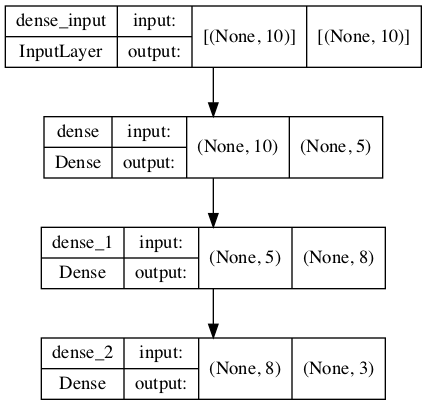

In [15]:
#create model picture
plot_model(model, "my_model.png", show_shapes=True, show_layer_names=True)

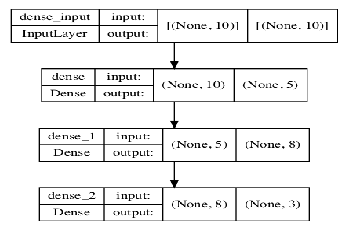

In [16]:
#show the image created
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

model_pic = mpimg.imread("my_model.png")
plt.imshow(model_pic, interpolation='nearest', aspect='auto')
plt.axis('off')
plt.show()

Before training a model, you need to configure the learning process, which is done via the `compile` method. It receives three arguments:
- **A loss function.** This is the objective that the model will try to minimize. It can be the string identifier of an existing loss function (such as categorical_crossentropy or mse), or it can be an objective function. See: [losses](https://faroit.com/keras-docs/2.0.8/losses).
- **An optimizer.** This could be the string identifier of an existing optimizer (such as rmsprop or adagrad), or an instance of the Optimizer class. See: [optimizers](https://faroit.com/keras-docs/2.0.8/optimizers).
- **A list of metrics.** For any classification problem you will want to set this to metrics=['accuracy']. A metric could be the string identifier of an existing metric or a custom metric function.

In [17]:
#compile model
model.compile(loss="sparse_categorical_crossentropy",
            optimizer="sgd" , #stochastic gradient descent
            metrics=["sparse_categorical_accuracy"])

In [18]:
#fit model
history = model.fit(X_train, y_train,    epochs=400,
         validation_data=(X_valid, y_valid),batch_size = 50)

Epoch 1/400
10/10 [==============================] - 1s 20ms/step - loss: 19.6535 - sparse_categorical_accuracy: 0.4040 - val_loss: 1.2281 - val_sparse_categorical_accuracy: 0.4300
Epoch 2/400
10/10 [==============================] - 0s 5ms/step - loss: 1.1437 - sparse_categorical_accuracy: 0.4680 - val_loss: 1.1492 - val_sparse_categorical_accuracy: 0.4320
Epoch 3/400
10/10 [==============================] - 0s 6ms/step - loss: 1.1017 - sparse_categorical_accuracy: 0.4660 - val_loss: 1.1280 - val_sparse_categorical_accuracy: 0.4340
Epoch 4/400
10/10 [==============================] - 0s 5ms/step - loss: 1.0848 - sparse_categorical_accuracy: 0.4660 - val_loss: 1.1201 - val_sparse_categorical_accuracy: 0.4340
Epoch 5/400
10/10 [==============================] - 0s 6ms/step - loss: 1.0802 - sparse_categorical_accuracy: 0.4680 - val_loss: 1.1173 - val_sparse_categorical_accuracy: 0.4340
Epoch 6/400
10/10 [==============================] - 0s 5ms/step - loss: 1.0776 - sparse_categorical_ac

10/10 [==============================] - 0s 5ms/step - loss: 1.0431 - sparse_categorical_accuracy: 0.4680 - val_loss: 1.0985 - val_sparse_categorical_accuracy: 0.4340
Epoch 47/400
10/10 [==============================] - 0s 5ms/step - loss: 1.0427 - sparse_categorical_accuracy: 0.4680 - val_loss: 1.0983 - val_sparse_categorical_accuracy: 0.4340
Epoch 48/400
10/10 [==============================] - 0s 5ms/step - loss: 1.0424 - sparse_categorical_accuracy: 0.4680 - val_loss: 1.0981 - val_sparse_categorical_accuracy: 0.4320
Epoch 49/400
10/10 [==============================] - 0s 5ms/step - loss: 1.0422 - sparse_categorical_accuracy: 0.4680 - val_loss: 1.0983 - val_sparse_categorical_accuracy: 0.4320
Epoch 50/400
10/10 [==============================] - 0s 6ms/step - loss: 1.0420 - sparse_categorical_accuracy: 0.4680 - val_loss: 1.0982 - val_sparse_categorical_accuracy: 0.4320
Epoch 51/400
10/10 [==============================] - 0s 6ms/step - loss: 1.0417 - sparse_categorical_accuracy: 0

10/10 [==============================] - 0s 4ms/step - loss: 1.0353 - sparse_categorical_accuracy: 0.4820 - val_loss: 1.1020 - val_sparse_categorical_accuracy: 0.4400
Epoch 92/400
10/10 [==============================] - 0s 5ms/step - loss: 1.0354 - sparse_categorical_accuracy: 0.4740 - val_loss: 1.1018 - val_sparse_categorical_accuracy: 0.4400
Epoch 93/400
10/10 [==============================] - 0s 5ms/step - loss: 1.0349 - sparse_categorical_accuracy: 0.4840 - val_loss: 1.1007 - val_sparse_categorical_accuracy: 0.4400
Epoch 94/400
10/10 [==============================] - 0s 5ms/step - loss: 1.0344 - sparse_categorical_accuracy: 0.4800 - val_loss: 1.1016 - val_sparse_categorical_accuracy: 0.4400
Epoch 95/400
10/10 [==============================] - 0s 5ms/step - loss: 1.0340 - sparse_categorical_accuracy: 0.4820 - val_loss: 1.1023 - val_sparse_categorical_accuracy: 0.4400
Epoch 96/400
10/10 [==============================] - 0s 6ms/step - loss: 1.0339 - sparse_categorical_accuracy: 0

10/10 [==============================] - 0s 5ms/step - loss: 1.0270 - sparse_categorical_accuracy: 0.4860 - val_loss: 1.1029 - val_sparse_categorical_accuracy: 0.4420
Epoch 137/400
10/10 [==============================] - 0s 5ms/step - loss: 1.0264 - sparse_categorical_accuracy: 0.4880 - val_loss: 1.1035 - val_sparse_categorical_accuracy: 0.4420
Epoch 138/400
10/10 [==============================] - 0s 5ms/step - loss: 1.0265 - sparse_categorical_accuracy: 0.4840 - val_loss: 1.1104 - val_sparse_categorical_accuracy: 0.4420
Epoch 139/400
10/10 [==============================] - 0s 6ms/step - loss: 1.0248 - sparse_categorical_accuracy: 0.4840 - val_loss: 1.1172 - val_sparse_categorical_accuracy: 0.4420
Epoch 140/400
10/10 [==============================] - 0s 5ms/step - loss: 1.0255 - sparse_categorical_accuracy: 0.4880 - val_loss: 1.1088 - val_sparse_categorical_accuracy: 0.4420
Epoch 141/400
10/10 [==============================] - 0s 4ms/step - loss: 1.0246 - sparse_categorical_accura

10/10 [==============================] - 0s 5ms/step - loss: 1.0052 - sparse_categorical_accuracy: 0.5440 - val_loss: 1.1620 - val_sparse_categorical_accuracy: 0.5140
Epoch 182/400
10/10 [==============================] - 0s 4ms/step - loss: 1.0082 - sparse_categorical_accuracy: 0.5440 - val_loss: 1.1362 - val_sparse_categorical_accuracy: 0.5140
Epoch 183/400
10/10 [==============================] - 0s 4ms/step - loss: 1.0059 - sparse_categorical_accuracy: 0.5460 - val_loss: 1.1510 - val_sparse_categorical_accuracy: 0.5160
Epoch 184/400
10/10 [==============================] - 0s 4ms/step - loss: 1.0069 - sparse_categorical_accuracy: 0.5460 - val_loss: 1.1562 - val_sparse_categorical_accuracy: 0.5180
Epoch 185/400
10/10 [==============================] - 0s 7ms/step - loss: 1.0073 - sparse_categorical_accuracy: 0.5460 - val_loss: 1.1600 - val_sparse_categorical_accuracy: 0.5180
Epoch 186/400
10/10 [==============================] - 0s 5ms/step - loss: 1.0065 - sparse_categorical_accura

10/10 [==============================] - 0s 7ms/step - loss: 0.9914 - sparse_categorical_accuracy: 0.5540 - val_loss: 1.3132 - val_sparse_categorical_accuracy: 0.5260
Epoch 227/400
10/10 [==============================] - 0s 5ms/step - loss: 0.9904 - sparse_categorical_accuracy: 0.5540 - val_loss: 1.3175 - val_sparse_categorical_accuracy: 0.5280
Epoch 228/400
10/10 [==============================] - 0s 5ms/step - loss: 0.9894 - sparse_categorical_accuracy: 0.5560 - val_loss: 1.3178 - val_sparse_categorical_accuracy: 0.5260
Epoch 229/400
10/10 [==============================] - 0s 5ms/step - loss: 0.9881 - sparse_categorical_accuracy: 0.5560 - val_loss: 1.3270 - val_sparse_categorical_accuracy: 0.5280
Epoch 230/400
10/10 [==============================] - 0s 5ms/step - loss: 0.9894 - sparse_categorical_accuracy: 0.5560 - val_loss: 1.3210 - val_sparse_categorical_accuracy: 0.5280
Epoch 231/400
10/10 [==============================] - 0s 4ms/step - loss: 0.9882 - sparse_categorical_accura

10/10 [==============================] - 0s 4ms/step - loss: 0.9701 - sparse_categorical_accuracy: 0.5700 - val_loss: 1.2694 - val_sparse_categorical_accuracy: 0.5320
Epoch 272/400
10/10 [==============================] - 0s 5ms/step - loss: 0.9693 - sparse_categorical_accuracy: 0.5680 - val_loss: 1.2763 - val_sparse_categorical_accuracy: 0.5320
Epoch 273/400
10/10 [==============================] - 0s 6ms/step - loss: 0.9684 - sparse_categorical_accuracy: 0.5700 - val_loss: 1.2952 - val_sparse_categorical_accuracy: 0.5340
Epoch 274/400
10/10 [==============================] - 0s 5ms/step - loss: 0.9700 - sparse_categorical_accuracy: 0.5700 - val_loss: 1.3021 - val_sparse_categorical_accuracy: 0.5340
Epoch 275/400
10/10 [==============================] - 0s 5ms/step - loss: 0.9687 - sparse_categorical_accuracy: 0.5680 - val_loss: 1.3061 - val_sparse_categorical_accuracy: 0.5340
Epoch 276/400
10/10 [==============================] - 0s 5ms/step - loss: 0.9687 - sparse_categorical_accura

10/10 [==============================] - 0s 4ms/step - loss: 0.9597 - sparse_categorical_accuracy: 0.5680 - val_loss: 1.2664 - val_sparse_categorical_accuracy: 0.5420
Epoch 317/400
10/10 [==============================] - 0s 4ms/step - loss: 0.9557 - sparse_categorical_accuracy: 0.5740 - val_loss: 1.2825 - val_sparse_categorical_accuracy: 0.5420
Epoch 318/400
10/10 [==============================] - 0s 4ms/step - loss: 0.9545 - sparse_categorical_accuracy: 0.5740 - val_loss: 1.2827 - val_sparse_categorical_accuracy: 0.5440
Epoch 319/400
10/10 [==============================] - 0s 4ms/step - loss: 0.9540 - sparse_categorical_accuracy: 0.5740 - val_loss: 1.2919 - val_sparse_categorical_accuracy: 0.5440
Epoch 320/400
10/10 [==============================] - 0s 5ms/step - loss: 0.9544 - sparse_categorical_accuracy: 0.5740 - val_loss: 1.2793 - val_sparse_categorical_accuracy: 0.5440
Epoch 321/400
10/10 [==============================] - 0s 5ms/step - loss: 0.9541 - sparse_categorical_accura

10/10 [==============================] - 0s 6ms/step - loss: 0.9309 - sparse_categorical_accuracy: 0.5880 - val_loss: 1.4704 - val_sparse_categorical_accuracy: 0.5460
Epoch 362/400
10/10 [==============================] - 0s 6ms/step - loss: 0.9301 - sparse_categorical_accuracy: 0.5900 - val_loss: 1.4764 - val_sparse_categorical_accuracy: 0.5420
Epoch 363/400
10/10 [==============================] - 0s 5ms/step - loss: 0.9328 - sparse_categorical_accuracy: 0.5860 - val_loss: 1.3844 - val_sparse_categorical_accuracy: 0.5340
Epoch 364/400
10/10 [==============================] - 0s 4ms/step - loss: 0.9353 - sparse_categorical_accuracy: 0.5800 - val_loss: 1.4023 - val_sparse_categorical_accuracy: 0.5440
Epoch 365/400
10/10 [==============================] - 0s 5ms/step - loss: 0.9338 - sparse_categorical_accuracy: 0.5880 - val_loss: 1.4302 - val_sparse_categorical_accuracy: 0.5440
Epoch 366/400
10/10 [==============================] - 0s 5ms/step - loss: 0.9318 - sparse_categorical_accura

(0.0, 2.0)

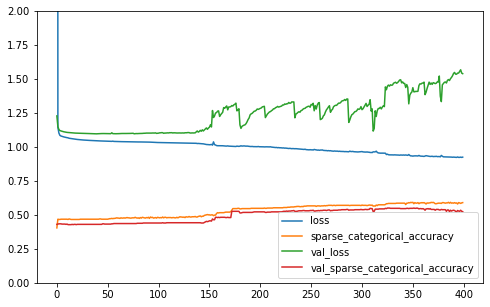

In [19]:
#Complete the code and plot your model
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.gca().set_ylim(0, 2)

#is your model overfitting or underfitting?
#A model is overfitting when:
#loss on train set decreasing
#loss on valid set stable/increasing

# if there is a overfitting/underfitting problem, you might need to decrease/increase your model complexity